In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import random
sns.set()
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import warnings
from keras.optimizers import Adam
warnings.filterwarnings("ignore")
np.random.seed(1)
from calendar import monthrange
import random
import tensorflow as tf
np.random.seed(28)
random.seed(28)
tf.random.set_seed(28)

# Importante

Para las redes neuronales estamos usandos Keras, el cual requiere de tensorflow en el back para poder usarse. Antes de correr ciertos algoritmos se deberá tener configurado el entorno.


pip install keras

pip install tensorflow

pip install pmdarima



Primero leemos los dataset por separado. Luego iremos formando diferentes dataset dependiendo del uso que necesitemos. En este caso los dataset inciales son oficiales por lo que se les ha realizado un pequeño preprocesado, es por ello que no se realiza la busqueda de null, ceros u otros valores que afecten al dataset.

Los dataset iniciales son de la demanda y la producción en bruto de la energía en Iraq por países. Para este proyecto se hará de la totalidad del país, es decir la suma de todos los piases y se analizarán como una serie de tiempo

In [2]:
datosDemandaBruto = pd.read_csv("Demand13.csv")
datosProduccionBruto = pd.read_csv("Supply13.csv")

In [3]:
print(datosDemandaBruto)
datosDemandaBruto.head()

       Hours  Baghdad  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1     3294   1243     757          488    471    598    525    514   
1          2     2973   1151     753          477    436    570    500    469   
2          3     2758   1105     727          471    419    604    478    430   
3          4     2703   1220     717          470    463    564    497    465   
4          5     2954   1358     751          519    515    626    553    517   
...      ...      ...    ...     ...          ...    ...    ...    ...    ...   
26347     20     4894   1906    1206         1008    912   1112   1112    914   
26348     21     4550   1798    1158          928    862   1047   1027    869   
26349     22     4326   1683    1091          868    818   1001    972    807   
26350     23     4090   1567     988          819    782    935    892    780   
26351     24     3954   1465     942          780    750    879    838    728   

       Najaf  Dywan.  Wasit

Hours  Baghdad  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0      1     3294   1243     757          488    471    598    525    514   
1      2     2973   1151     753          477    436    570    500    469   
2      3     2758   1105     727          471    419    604    478    430   
3      4     2703   1220     717          470    463    564    497    465   
4      5     2954   1358     751          519    515    626    553    517   

   Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesan  Basrah  
0    474     307    404      208      573    369    1254  
1    437     284    374      193      536    342    1100  
2    420     273    359      185      519    328    1056  
3    451     301    397      204      522    363    1100  
4    502     335    442      228      574    404    1298

In [4]:
print(datosProduccionBruto)
datosProduccionBruto.head()

       Hours  Bagh.  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1   3294    740     668          488    394    598    525    514   
1          2   2973    751     753          477    387    570    500    469   
2          3   2758    760     727          471    374    604    478    430   
3          4   2703    759     717          470    365    546    490    433   
4          5   2794    727     751          470    374    578    539    472   
...      ...    ...    ...     ...          ...    ...    ...    ...    ...   
26347     20   3364    765     762          418    421    587    648    608   
26348     21   3437    748     751          412    418    617    678    638   
26349     22   3368    761     751          420    411    603    719    689   
26350     23   3373    801     782          424    406    614    663    681   
26351     24   3169    853     759          422    404    604    568    593   

       Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesa

Hours  Bagh.  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0      1   3294    740     668          488    394    598    525    514   
1      2   2973    751     753          477    387    570    500    469   
2      3   2758    760     727          471    374    604    478    430   
3      4   2703    759     717          470    365    546    490    433   
4      5   2794    727     751          470    374    578    539    472   

   Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesan  Basrah  
0    474     246    397      185      573    294    1104  
1    437     223    362      177      536    269    1030  
2    420     210    347      169      519    229     956  
3    420     202    350      172      522    232     953  
4    449     246    389      191      574    275    1003

Para el total de horas sumaremos el valor de todas las columna, ya que cada columna representa el valor de cada provincia, creando una nueva columna con esto mismo.

In [5]:
datosDemandaTotalHoras = pd.DataFrame()
datosProduccionTotalHoras = pd.DataFrame()

In [6]:
datosDemandaTotalHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [7]:
datosDemandaTotalHoras["Hours"] = datosDemandaBruto["Hours"]
datosProduccionTotalHoras["Hours"] = datosProduccionBruto["Hours"]

In [8]:
datosDemandaTotalSinHoras = pd.DataFrame()
datosProduccionTotalSinHoras = pd.DataFrame()

In [9]:
datosDemandaTotalSinHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalSinHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [10]:
datosDemandaTotalHoras.head()


total  Hours
0  11479      1
1  10595      2
2  10132      3
3  10437      4
4  11576      5

In [11]:
datosDemandaTotalSinHoras.head()

total
0  11479
1  10595
2  10132
3  10437
4  11576

Ahora partimos de un nuevo dataset el cual tiene una columna con las demanda/produccion por horas, es decir cada fila es una hora y cada 24 filas es un día. Una vez tenemos estos dos dataset, vamos a pasar estas horas a dias para tener los otros dos dataset faltantes.

In [12]:
suma_24_demanda = []
suma_24_produccion = []

In [13]:
for i in range(0, len(datosDemandaTotalSinHoras), 24):
    end = i + 24
    if end > len(datosDemandaTotalSinHoras):
        end = len(datosDemandaTotalSinHoras)
    suma_24_demanda.append(datosDemandaTotalSinHoras[i:end].sum(axis=0).sum())

In [14]:
for i in range(0, len(datosProduccionTotalSinHoras), 24):
    end = i + 24
    if end > len(datosProduccionTotalSinHoras):
        end = len(datosProduccionTotalSinHoras)
    suma_24_produccion.append(datosProduccionTotalSinHoras[i:end].sum(axis=0).sum())

In [15]:
datosDemandaTotalDias = pd.DataFrame({'Total': suma_24_demanda})
datosProduccionTotalDias = pd.DataFrame({'Total': suma_24_produccion})

In [16]:
diasDemanda = pd.date_range(start='2019-01-01', periods=len(suma_24_demanda), freq='D')
diasProduccion = pd.date_range(start='2019-01-01', periods=len(suma_24_produccion), freq='D')

In [17]:
datosDemandaTotalDias["fecha"] = diasDemanda
datosProduccionTotalDias["fecha"] = diasProduccion

Despues de hacer todas estas transformaciones ya tenemos los 4 dataset que queremos: datosDemandaTotalHoras/datosProduccionTotalHoras los cuales tiene la produccion total por ahora y datosDemandaTotalDias/datosProduccionTotalDias los cuales tienen la produccion por dias

In [18]:
datosDemandaTotalHoras.head()


total  Hours
0  11479      1
1  10595      2
2  10132      3
3  10437      4
4  11576      5

In [19]:
datosProduccionTotalHoras.head()

total  Hours
0  10494      1
1   9914      2
2   9452      3
3   9334      4
4   9832      5

In [20]:
datosHorariosDemanda = datosDemandaTotalHoras.rename(columns={'total': 'Demanda'})
datosHorariosDemanda

Demanda  Hours
0        11479      1
1        10595      2
2        10132      3
3        10437      4
4        11576      5
...        ...    ...
26347    19725     20
26348    18376     21
26349    17323     22
26350    16220     23
26351    15341     24

[26352 rows x 2 columns]

In [21]:
datosHorariosProduccion = datosProduccionTotalHoras.rename(columns={'total': 'Produccion'})
datosHorariosProduccion

Produccion  Hours
0           10494      1
1            9914      2
2            9452      3
3            9334      4
4            9832      5
...           ...    ...
26347       12754     20
26348       12639     21
26349       12320     22
26350       11802     23
26351       11000     24

[26352 rows x 2 columns]

In [22]:
datosHorariosProduccion['Demanda'] = datosHorariosDemanda['Demanda']
datosHorariosProduccion

Produccion  Hours  Demanda
0           10494      1    11479
1            9914      2    10595
2            9452      3    10132
3            9334      4    10437
4            9832      5    11576
...           ...    ...      ...
26347       12754     20    19725
26348       12639     21    18376
26349       12320     22    17323
26350       11802     23    16220
26351       11000     24    15341

[26352 rows x 3 columns]

In [23]:
datosDemandaTotalDias.head()

Total      fecha
0  379726 2019-01-01
1  383590 2019-01-02
2  378901 2019-01-03
3  378180 2019-01-04
4  385805 2019-01-05

In [24]:
datosProduccionTotalDias.head()

Total      fecha
0  289005 2019-01-01
1  288843 2019-01-02
2  283581 2019-01-03
3  285621 2019-01-04
4  283991 2019-01-05

In [25]:
data = pd.merge(datosDemandaTotalDias, datosProduccionTotalDias, on='fecha')

In [26]:
data = data.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})

In [27]:
data = data.set_index('fecha')

In [28]:
data = data[data.index < pd.to_datetime("31-12-2021")]

In [29]:
data.info()
data


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2019-01-01 to 2021-12-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Demanda     1095 non-null   int64
 1   Produccion  1095 non-null   int64
dtypes: int64(2)
memory usage: 25.7 KB


Demanda  Produccion
fecha                          
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-26   466243      299610
2021-12-27   435243      291977
2021-12-28   420410      279246
2021-12-29   411592      261122
2021-12-30   378184      248905

[1095 rows x 2 columns]

# Estudio de estaciones

Después de informarme un poco sobre el país, he cogido las 4 estaciones según los meses para ver si hay alguna relación. De primera intuición podemos imaginar que a ser un país caluroso en verano y fresco en invierno, en estas estaciones deberíamos tener mayor demanda en estos periodos

In [30]:
estaciones = {
    1: 'Invierno',
    2: 'Invierno',
    3: 'Invierno',
    4: 'Primavera',
    5: 'Primavera',
    6: 'Verano',
    7: 'Verano',
    8: 'Verano',
    9: 'Verano',
    10: 'Otoño',
    11: 'Otoño',
    12: 'Invierno'
}

In [31]:
dataEstacion = data.copy()

In [32]:
dataEstacion['estacion'] = data.index.month.map(estaciones)

In [33]:
dataEstacion.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2019-01-01 to 2021-12-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Demanda     1095 non-null   int64 
 1   Produccion  1095 non-null   int64 
 2   estacion    1095 non-null   object
dtypes: int64(2), object(1)
memory usage: 34.2+ KB


In [34]:
dataEstacion

Demanda  Produccion  estacion
fecha                                    
2019-01-01   379726      289005  Invierno
2019-01-02   383590      288843  Invierno
2019-01-03   378901      283581  Invierno
2019-01-04   378180      285621  Invierno
2019-01-05   385805      283991  Invierno
...             ...         ...       ...
2021-12-26   466243      299610  Invierno
2021-12-27   435243      291977  Invierno
2021-12-28   420410      279246  Invierno
2021-12-29   411592      261122  Invierno
2021-12-30   378184      248905  Invierno

[1095 rows x 3 columns]

In [35]:
dataEstacion2 = dataEstacion.copy()

In [36]:
dataEstacion2.groupby(['estacion'])['Demanda'].mean()

estacion
Invierno     367675.931129
Otoño        342338.863388
Primavera    365714.278689
Verano       540844.855191
Name: Demanda, dtype: float64

In [37]:
dataEstacion2.groupby(['estacion'])['Produccion'].mean()

estacion
Invierno     268132.415978
Otoño        283917.808743
Primavera    306742.420765
Verano       403776.814208
Name: Produccion, dtype: float64

<Axes: xlabel='fecha'>

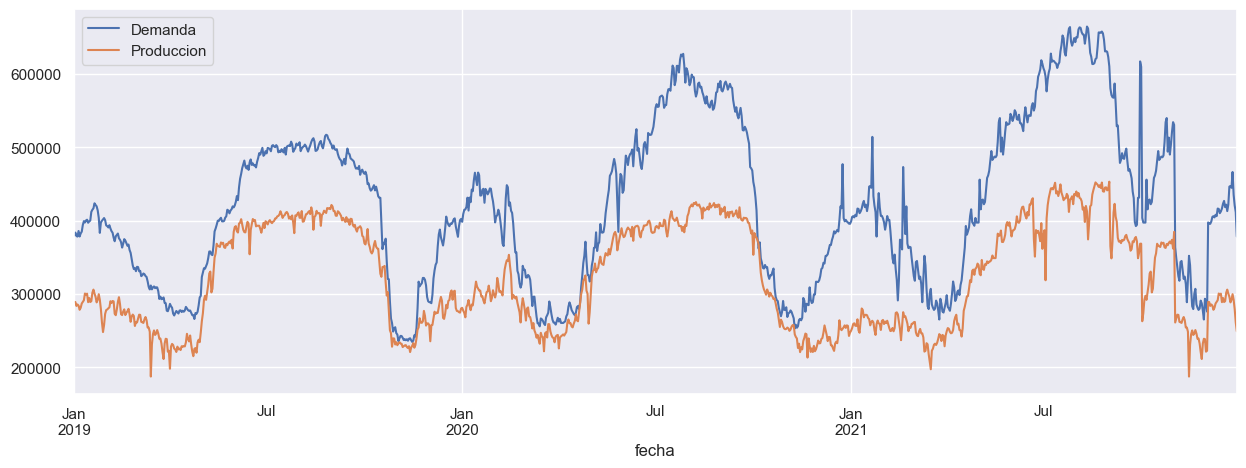

In [38]:
dataEstacion2.plot(figsize=(15,5))

Ahora vamos a entrenar una red LSTM con los años 2019 y 2020 para ver si es capaz de predecir las estaciones en 2021
Para ello con convertiremos las etiquetas de estaciones del año a una forma numérica (codificación one-hot) para que el modelo pueda entenderlas.
Se va a probar con ventanas de 7,30,60,100,180 dias  
Todo esto cogiendo una sola caracteristica luego, la realizaré con las dos para comparar resultados



In [39]:
dataLSTMEstacion = dataEstacion.copy()

In [40]:
#dataLSTMEstacion.to_csv("aa.csv", index=False)

In [41]:
dataLSTMEstacion

Demanda  Produccion  estacion
fecha                                    
2019-01-01   379726      289005  Invierno
2019-01-02   383590      288843  Invierno
2019-01-03   378901      283581  Invierno
2019-01-04   378180      285621  Invierno
2019-01-05   385805      283991  Invierno
...             ...         ...       ...
2021-12-26   466243      299610  Invierno
2021-12-27   435243      291977  Invierno
2021-12-28   420410      279246  Invierno
2021-12-29   411592      261122  Invierno
2021-12-30   378184      248905  Invierno

[1095 rows x 3 columns]

### Prediccion estaciones según solo demanda

In [42]:
def estaciones_LSTM_demanda(dataLSTMEstacion, look_back):
    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(dataLSTMEstacion['estacion'].values.reshape(-1, 1))
    #reciclo la función, podría crearla arriba y llamarla, pero en todas tengo que hacer pequeños cambios, para futuras mejoras
    def dataset_X(X, look_back):
        dataX = []
        for i in range(len(X) - look_back):
            dataX.append(X[i:(i + look_back)])
        return np.array(dataX)

    def dataset_Y(Y, look_back):
        return Y[look_back:]
    #solo cojo la demanda para predecir la estacion
    X_data = dataset_X(dataLSTMEstacion[['Demanda']].values, look_back)
    Y_data = dataset_Y(y_encoded, look_back)
    
    years_train = (dataLSTMEstacion.index.year == 2019) | (dataLSTMEstacion.index.year == 2020)
    years_test = dataLSTMEstacion.index.year == 2021
    X_train = X_data[years_train[:-look_back]]
    Y_train = Y_data[years_train[:-look_back]]
    X_test = X_data[years_test[:-look_back]]
    Y_test = Y_data[years_test[:-look_back]]
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    fit_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)
    
    #para mostrar resultados
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))



    Cogiendo 7 dias antes

In [43]:
estaciones_LSTM_demanda(dataLSTMEstacion, 7)


Epoch 1/20
23/23 [==============================] - 2s 28ms/step - loss: 1.4423 - accuracy: 0.3338 - val_loss: 1.4104 - val_accuracy: 0.3417
Epoch 2/20
23/23 [==============================] - 0s 5ms/step - loss: 1.4006 - accuracy: 0.3338 - val_loss: 1.3784 - val_accuracy: 0.3417
Epoch 3/20
23/23 [==============================] - 0s 5ms/step - loss: 1.3717 - accuracy: 0.3338 - val_loss: 1.3588 - val_accuracy: 0.3417
Epoch 4/20
23/23 [==============================] - 0s 5ms/step - loss: 1.3538 - accuracy: 0.3338 - val_loss: 1.3469 - val_accuracy: 0.3417
Epoch 5/20
23/23 [==============================] - 0s 5ms/step - loss: 1.3430 - accuracy: 0.3338 - val_loss: 1.3407 - val_accuracy: 0.3417
Epoch 6/20
19/23 [=======================>......] - ETA: 0s - loss: 1.3388 - accuracy: 0.3372

23/23 [==============================] - 0s 5ms/step - loss: 1.3369 - accuracy: 0.3338 - val_loss: 1.3376 - val_accuracy: 0.3417
Epoch 7/20
23/23 [==============================] - 0s 6ms/step - loss: 1.3336 - accuracy: 0.3338 - val_loss: 1.3362 - val_accuracy: 0.3417
Epoch 8/20
23/23 [==============================] - 0s 5ms/step - loss: 1.3320 - accuracy: 0.3338 - val_loss: 1.3355 - val_accuracy: 0.3417
Epoch 9/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3312 - accuracy: 0.3338 - val_loss: 1.3353 - val_accuracy: 0.3417
Epoch 10/20
23/23 [==============================] - 0s 5ms/step - loss: 1.3312 - accuracy: 0.2941 - val_loss: 1.3353 - val_accuracy: 0.3417
Epoch 11/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3310 - accuracy: 0.2982 - val_loss: 1.3354 - val_accuracy: 0.3417
Epoch 12/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3306 - accuracy: 0.3338 - val_loss: 1.3351 - val_accuracy: 0.3417
Epoch 13/20
23/23 [=========

    Cogiendo 30 dias antes

In [44]:
estaciones_LSTM_demanda(dataLSTMEstacion, 30)

Epoch 1/20
23/23 [==============================] - 2s 25ms/step - loss: 1.3915 - accuracy: 0.2298 - val_loss: 1.3864 - val_accuracy: 0.2695
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 1.3597 - accuracy: 0.3324 - val_loss: 1.3663 - val_accuracy: 0.2695
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 1.3431 - accuracy: 0.3324 - val_loss: 1.3569 - val_accuracy: 0.2695
Epoch 4/20
23/23 [==============================] - 0s 11ms/step - loss: 1.3363 - accuracy: 0.3324 - val_loss: 1.3528 - val_accuracy: 0.2695
Epoch 5/20
23/23 [==============================] - 0s 9ms/step - loss: 1.3328 - accuracy: 0.3324 - val_loss: 1.3526 - val_accuracy: 0.2695
Epoch 6/20
23/23 [==============================] - 0s 10ms/step - loss: 1.3311 - accuracy: 0.3324 - val_loss: 1.3510 - val_accuracy: 0.2695
Epoch 7/20
23/23 [==============================] - 0s 10ms/step - loss: 1.3307 - accuracy: 0.3187 - val_loss: 1.3506 - val_accuracy: 0.3653
Epoch 8/20
23/2

    Cogiendo 60 dias antes

In [45]:
estaciones_LSTM_demanda(dataLSTMEstacion, 60)

Epoch 1/20
23/23 [==============================] - 2s 30ms/step - loss: 1.5003 - accuracy: 0.2339 - val_loss: 1.3617 - val_accuracy: 0.4013
Epoch 2/20
23/23 [==============================] - 0s 15ms/step - loss: 1.4082 - accuracy: 0.3338 - val_loss: 1.3389 - val_accuracy: 0.4013
Epoch 3/20
23/23 [==============================] - 0s 15ms/step - loss: 1.3594 - accuracy: 0.3338 - val_loss: 1.3425 - val_accuracy: 0.4013
Epoch 4/20
23/23 [==============================] - 0s 16ms/step - loss: 1.3394 - accuracy: 0.3338 - val_loss: 1.3545 - val_accuracy: 0.4013
Epoch 5/20
23/23 [==============================] - 0s 16ms/step - loss: 1.3331 - accuracy: 0.3338 - val_loss: 1.3684 - val_accuracy: 0.4013
Epoch 6/20
23/23 [==============================] - 0s 15ms/step - loss: 1.3308 - accuracy: 0.3338 - val_loss: 1.3726 - val_accuracy: 0.4013
Epoch 7/20
23/23 [==============================] - 0s 17ms/step - loss: 1.3309 - accuracy: 0.3338 - val_loss: 1.3749 - val_accuracy: 0.4013
Epoch 8/20
23

    Cogiendo 100 dias antes

In [46]:
estaciones_LSTM_demanda(dataLSTMEstacion, 100)

Epoch 1/20
23/23 [==============================] - 2s 50ms/step - loss: 1.8159 - accuracy: 0.1669 - val_loss: 1.7394 - val_accuracy: 0.2311
Epoch 2/20
23/23 [==============================] - 1s 27ms/step - loss: 1.5988 - accuracy: 0.1669 - val_loss: 1.6020 - val_accuracy: 0.2311
Epoch 3/20
23/23 [==============================] - 1s 27ms/step - loss: 1.4679 - accuracy: 0.1696 - val_loss: 1.5097 - val_accuracy: 0.1136
Epoch 4/20
23/23 [==============================] - 1s 26ms/step - loss: 1.3947 - accuracy: 0.3324 - val_loss: 1.4500 - val_accuracy: 0.1136
Epoch 5/20
23/23 [==============================] - 1s 27ms/step - loss: 1.3586 - accuracy: 0.3324 - val_loss: 1.4180 - val_accuracy: 0.1136
Epoch 6/20
23/23 [==============================] - 1s 27ms/step - loss: 1.3421 - accuracy: 0.3324 - val_loss: 1.4020 - val_accuracy: 0.1136
Epoch 7/20
23/23 [==============================] - 1s 27ms/step - loss: 1.3345 - accuracy: 0.3324 - val_loss: 1.3871 - val_accuracy: 0.1136
Epoch 8/20
23

### Prediccion estaciones según solo produccion

In [47]:
def estaciones_LSTM_produccion(dataLSTMEstacion, look_back):
    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(dataLSTMEstacion['estacion'].values.reshape(-1, 1))
    #reciclo la función, podría crearla arriba y llamarla, pero en todas tengo que hacer pequeños cambios, para futuras mejoras
    def dataset_X(X, look_back):
        dataX = []
        for i in range(len(X) - look_back):
            dataX.append(X[i:(i + look_back)])
        return np.array(dataX)

    def dataset_Y(Y, look_back):
        return Y[look_back:]
    #solo cojo la produccion para predecir la estacion
    X_data = dataset_X(dataLSTMEstacion[['Produccion']].values, look_back)
    Y_data = dataset_Y(y_encoded, look_back)
    
    years_train = (dataLSTMEstacion.index.year == 2019) | (dataLSTMEstacion.index.year == 2020)
    years_test = dataLSTMEstacion.index.year == 2021
    X_train = X_data[years_train[:-look_back]]
    Y_train = Y_data[years_train[:-look_back]]
    X_test = X_data[years_test[:-look_back]]
    Y_test = Y_data[years_test[:-look_back]]
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    fit_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)
    
    #para mostrar resultados
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))


    Cogiendo 7 dias antes

In [48]:
estaciones_LSTM_produccion(dataLSTMEstacion, 7)

Epoch 1/20
23/23 [==============================] - 2s 17ms/step - loss: 1.3503 - accuracy: 0.3324 - val_loss: 1.3407 - val_accuracy: 0.3165
Epoch 2/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3338 - accuracy: 0.3324 - val_loss: 1.3354 - val_accuracy: 0.3417
Epoch 3/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3312 - accuracy: 0.3078 - val_loss: 1.3354 - val_accuracy: 0.3417
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3312 - accuracy: 0.3338 - val_loss: 1.3355 - val_accuracy: 0.3417
Epoch 5/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3305 - accuracy: 0.2955 - val_loss: 1.3354 - val_accuracy: 0.3165
Epoch 6/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3308 - accuracy: 0.3051 - val_loss: 1.3352 - val_accuracy: 0.3417
Epoch 7/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3306 - accuracy: 0.3338 - val_loss: 1.3354 - val_accuracy: 0.3417
Epoch 8/20
23/23 [=

    Cogiendo 30 dias antes

In [49]:
estaciones_LSTM_produccion(dataLSTMEstacion, 30)

Epoch 1/20
23/23 [==============================] - 2s 22ms/step - loss: 1.3565 - accuracy: 0.3324 - val_loss: 1.3718 - val_accuracy: 0.2695
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 1.3367 - accuracy: 0.3324 - val_loss: 1.3550 - val_accuracy: 0.2695
Epoch 3/20
23/23 [==============================] - 0s 8ms/step - loss: 1.3314 - accuracy: 0.3311 - val_loss: 1.3509 - val_accuracy: 0.3653
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 1.3311 - accuracy: 0.3338 - val_loss: 1.3507 - val_accuracy: 0.3653
Epoch 5/20
23/23 [==============================] - 0s 8ms/step - loss: 1.3306 - accuracy: 0.3160 - val_loss: 1.3525 - val_accuracy: 0.2695
Epoch 6/20
23/23 [==============================] - 0s 8ms/step - loss: 1.3303 - accuracy: 0.3256 - val_loss: 1.3509 - val_accuracy: 0.3653
Epoch 7/20
23/23 [==============================] - 0s 8ms/step - loss: 1.3306 - accuracy: 0.3338 - val_loss: 1.3506 - val_accuracy: 0.3653
Epoch 8/20
23/23 [=

    Cogiendo 60 dias antes

In [50]:
estaciones_LSTM_produccion(dataLSTMEstacion, 60)

Epoch 1/20
23/23 [==============================] - 2s 28ms/step - loss: 1.3658 - accuracy: 0.3324 - val_loss: 1.3995 - val_accuracy: 0.1974
Epoch 2/20
23/23 [==============================] - 0s 14ms/step - loss: 1.3348 - accuracy: 0.3324 - val_loss: 1.3803 - val_accuracy: 0.1974
Epoch 3/20
23/23 [==============================] - 0s 14ms/step - loss: 1.3306 - accuracy: 0.3256 - val_loss: 1.3725 - val_accuracy: 0.4013
Epoch 4/20
23/23 [==============================] - 0s 14ms/step - loss: 1.3314 - accuracy: 0.3338 - val_loss: 1.3730 - val_accuracy: 0.4013
Epoch 5/20
23/23 [==============================] - 0s 14ms/step - loss: 1.3309 - accuracy: 0.3078 - val_loss: 1.3806 - val_accuracy: 0.1974
Epoch 6/20
23/23 [==============================] - 0s 14ms/step - loss: 1.3307 - accuracy: 0.3297 - val_loss: 1.3757 - val_accuracy: 0.4013
Epoch 7/20
23/23 [==============================] - 0s 14ms/step - loss: 1.3309 - accuracy: 0.3338 - val_loss: 1.3759 - val_accuracy: 0.4013
Epoch 8/20
23

    Cogiendo 100 dias antes

In [51]:
estaciones_LSTM_produccion(dataLSTMEstacion, 100)

Epoch 1/20
23/23 [==============================] - 2s 39ms/step - loss: 1.3361 - accuracy: 0.3338 - val_loss: 1.3701 - val_accuracy: 0.4621
Epoch 2/20
23/23 [==============================] - 1s 25ms/step - loss: 1.3327 - accuracy: 0.3338 - val_loss: 1.3800 - val_accuracy: 0.4621
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 1.3311 - accuracy: 0.3338 - val_loss: 1.3825 - val_accuracy: 0.4621
Epoch 4/20
23/23 [==============================] - 1s 25ms/step - loss: 1.3310 - accuracy: 0.3338 - val_loss: 1.3848 - val_accuracy: 0.4621
Epoch 5/20
23/23 [==============================] - 1s 25ms/step - loss: 1.3303 - accuracy: 0.3338 - val_loss: 1.3903 - val_accuracy: 0.4621
Epoch 6/20
23/23 [==============================] - 1s 25ms/step - loss: 1.3304 - accuracy: 0.3338 - val_loss: 1.3933 - val_accuracy: 0.4621
Epoch 7/20
23/23 [==============================] - 1s 26ms/step - loss: 1.3304 - accuracy: 0.3338 - val_loss: 1.3898 - val_accuracy: 0.4621
Epoch 8/20
23

### Prediccion estaciones con ambas características


In [52]:
def estaciones_LSTM(dataLSTMEstacion, look_back):
    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(dataLSTMEstacion['estacion'].values.reshape(-1, 1))

    def dataset_X(X, look_back):
        dataX = []
        for i in range(len(X) - look_back):
            dataX.append(X[i:(i + look_back)])
        return np.array(dataX)

    def dataset_Y(Y, look_back):
        return Y[look_back:]

    # Ahora cojo tanto la Demanda como la Producción para predecir la estacion
    X_data = dataset_X(dataLSTMEstacion[['Demanda', 'Produccion']].values, look_back)
    Y_data = dataset_Y(y_encoded, look_back)
    
    years_train = (dataLSTMEstacion.index.year == 2019) | (dataLSTMEstacion.index.year == 2020)
    years_test = dataLSTMEstacion.index.year == 2021
    X_train = X_data[years_train[:-look_back]]
    Y_train = Y_data[years_train[:-look_back]]
    X_test = X_data[years_test[:-look_back]]
    Y_test = Y_data[years_test[:-look_back]]
    
    model = Sequential()
    # cambio la forma de entrada para que tenga 2 características en lugar de 1
    model.add(LSTM(50, input_shape=(look_back, 2)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    fit_model = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=1)
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(Y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred_classes, target_names=encoder.categories_[0]))


    Cogiendo 7 dias antes

In [53]:
estaciones_LSTM(dataLSTMEstacion, 7)

Epoch 1/20
23/23 [==============================] - 2s 18ms/step - loss: 1.4423 - accuracy: 0.1751 - val_loss: 1.3515 - val_accuracy: 0.2997
Epoch 2/20
23/23 [==============================] - 0s 4ms/step - loss: 1.3293 - accuracy: 0.3297 - val_loss: 1.3418 - val_accuracy: 0.3333
Epoch 3/20
23/23 [==============================] - 0s 4ms/step - loss: 1.2728 - accuracy: 0.4036 - val_loss: 1.3450 - val_accuracy: 0.3557
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 1.2897 - accuracy: 0.3735 - val_loss: 1.3409 - val_accuracy: 0.3754
Epoch 5/20
23/23 [==============================] - 0s 4ms/step - loss: 1.2826 - accuracy: 0.3803 - val_loss: 1.3103 - val_accuracy: 0.3641
Epoch 6/20
23/23 [==============================] - 0s 4ms/step - loss: 1.2801 - accuracy: 0.3611 - val_loss: 1.3343 - val_accuracy: 0.3585
Epoch 7/20
23/23 [==============================] - 0s 4ms/step - loss: 1.2752 - accuracy: 0.4049 - val_loss: 1.3342 - val_accuracy: 0.3557
Epoch 8/20
23/23 [=

    Cogiendo 30 dias antes

In [54]:
estaciones_LSTM(dataLSTMEstacion, 30)

Epoch 1/20
23/23 [==============================] - 2s 23ms/step - loss: 1.5930 - accuracy: 0.1970 - val_loss: 1.4691 - val_accuracy: 0.1257
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 1.4056 - accuracy: 0.3789 - val_loss: 1.3425 - val_accuracy: 0.3563
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 1.3219 - accuracy: 0.4104 - val_loss: 1.3095 - val_accuracy: 0.3593
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 1.2791 - accuracy: 0.3940 - val_loss: 1.3030 - val_accuracy: 0.4281
Epoch 5/20
23/23 [==============================] - 0s 9ms/step - loss: 1.2614 - accuracy: 0.3379 - val_loss: 1.3136 - val_accuracy: 0.4611
Epoch 6/20
23/23 [==============================] - 0s 9ms/step - loss: 1.2522 - accuracy: 0.3406 - val_loss: 1.3071 - val_accuracy: 0.4611
Epoch 7/20
23/23 [==============================] - 0s 9ms/step - loss: 1.2421 - accuracy: 0.3311 - val_loss: 1.3008 - val_accuracy: 0.4611
Epoch 8/20
23/23 [=

    Cogiendo 60 dias antes

In [55]:
estaciones_LSTM(dataLSTMEstacion, 60)

Epoch 1/20
23/23 [==============================] - 2s 43ms/step - loss: 1.4036 - accuracy: 0.3447 - val_loss: 1.4128 - val_accuracy: 0.1809
Epoch 2/20
23/23 [==============================] - 0s 17ms/step - loss: 1.3981 - accuracy: 0.2791 - val_loss: 1.4108 - val_accuracy: 0.1809
Epoch 3/20
23/23 [==============================] - 0s 16ms/step - loss: 1.3894 - accuracy: 0.2449 - val_loss: 1.4034 - val_accuracy: 0.1842
Epoch 4/20
23/23 [==============================] - 0s 16ms/step - loss: 1.3702 - accuracy: 0.2476 - val_loss: 1.3998 - val_accuracy: 0.3914
Epoch 5/20
23/23 [==============================] - 0s 16ms/step - loss: 1.3622 - accuracy: 0.2517 - val_loss: 1.4059 - val_accuracy: 0.1809
Epoch 6/20
23/23 [==============================] - 0s 16ms/step - loss: 1.3548 - accuracy: 0.2613 - val_loss: 1.4039 - val_accuracy: 0.1809
Epoch 7/20
23/23 [==============================] - 0s 17ms/step - loss: 1.3484 - accuracy: 0.2613 - val_loss: 1.4070 - val_accuracy: 0.1809
Epoch 8/20
23

    Cogiendo 100 dias antes

In [56]:
estaciones_LSTM(dataLSTMEstacion, 100)

Epoch 1/20
23/23 [==============================] - 2s 40ms/step - loss: 1.3664 - accuracy: 0.3352 - val_loss: 1.3258 - val_accuracy: 0.3371
Epoch 2/20
23/23 [==============================] - 1s 27ms/step - loss: 1.3607 - accuracy: 0.2969 - val_loss: 1.3733 - val_accuracy: 0.4621
Epoch 3/20
23/23 [==============================] - 1s 26ms/step - loss: 1.3300 - accuracy: 0.3338 - val_loss: 1.3842 - val_accuracy: 0.4621
Epoch 4/20
23/23 [==============================] - 1s 26ms/step - loss: 1.3211 - accuracy: 0.3338 - val_loss: 1.3954 - val_accuracy: 0.4621
Epoch 5/20
23/23 [==============================] - 1s 27ms/step - loss: 1.3254 - accuracy: 0.3338 - val_loss: 1.4084 - val_accuracy: 0.4621
Epoch 6/20
23/23 [==============================] - 1s 26ms/step - loss: 1.3236 - accuracy: 0.3694 - val_loss: 1.4115 - val_accuracy: 0.3750
Epoch 7/20
23/23 [==============================] - 1s 26ms/step - loss: 1.3183 - accuracy: 0.3735 - val_loss: 1.3935 - val_accuracy: 0.4167
Epoch 8/20
23

# Estudio Covid


In [57]:
dataPreCovid = data[data.index <= pd.to_datetime("23-feb-2020")]
dataPreCovid = dataPreCovid[pd.to_datetime("15-12-2019") <= dataPreCovid.index ]
dataPreCovid

Demanda  Produccion
fecha                          
2019-12-15   375697      265910
2019-12-16   389443      272995
2019-12-17   405381      285184
2019-12-18   398381      280298
2019-12-19   394335      290496
...             ...         ...
2020-02-19   375118      296528
2020-02-20   356693      293828
2020-02-21   356625      296104
2020-02-22   331468      287810
2020-02-23   326824      281290

[71 rows x 2 columns]

<Axes: xlabel='fecha'>

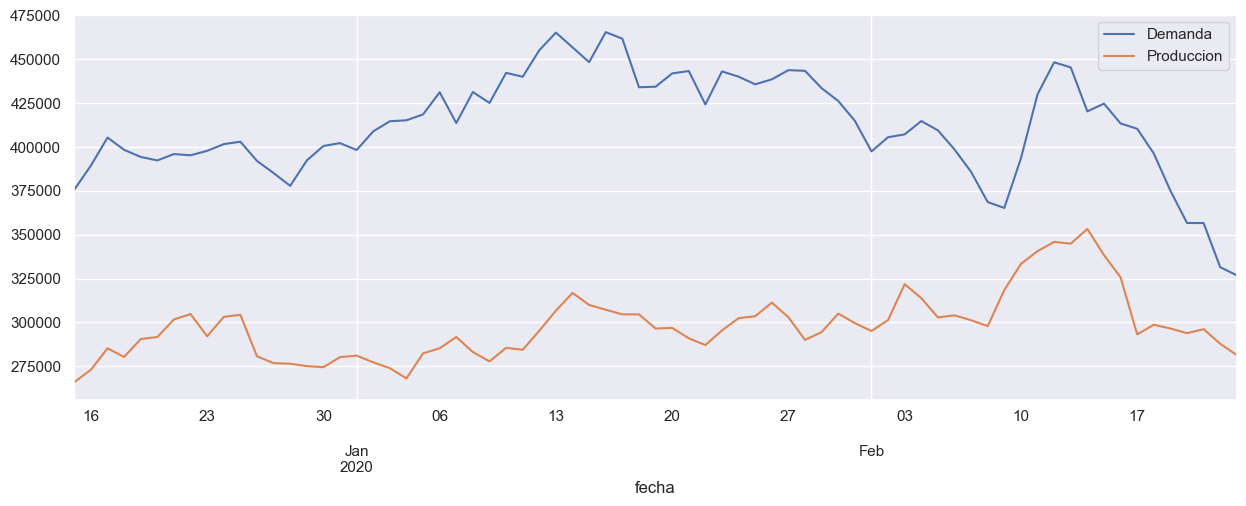

In [58]:
dataPreCovid.plot(figsize=(15,5))

In [59]:
dataCovid = data[data.index <= pd.to_datetime("30-04-2020")].copy()
dataCovid = dataCovid[pd.to_datetime("24-02-2020") <= dataCovid.index ]
dataCovid

Demanda  Produccion
fecha                          
2020-02-24   314394      274931
2020-02-25   308539      261047
2020-02-26   313477      282819
2020-02-27   338249      294075
2020-02-28   332861      286547
...             ...         ...
2020-04-26   371136      325099
2020-04-27   344921      304380
2020-04-28   325709      300122
2020-04-29   325771      259414
2020-04-30   316859      274876

[67 rows x 2 columns]

<Axes: xlabel='fecha'>

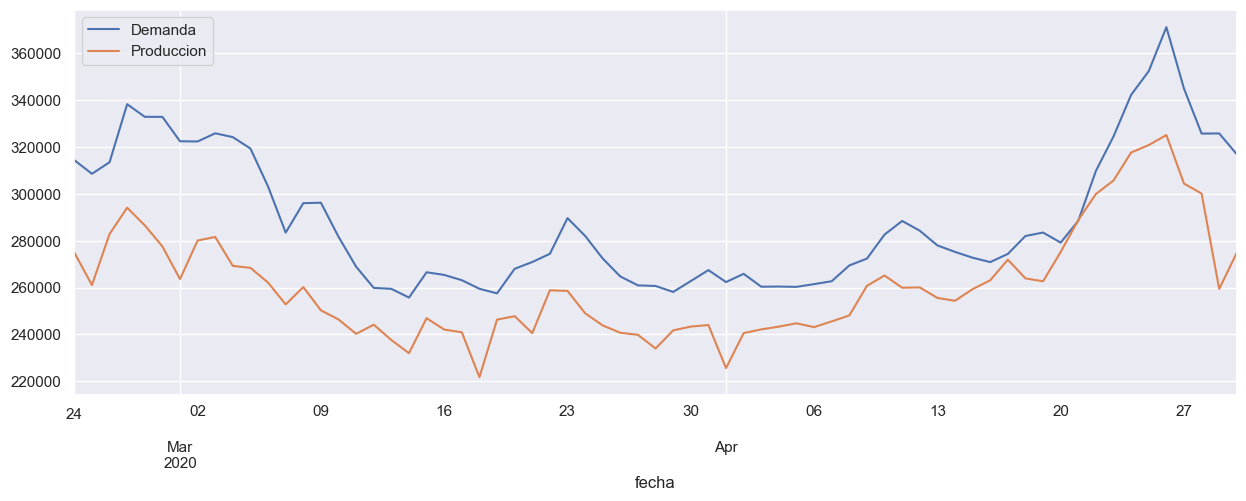

In [60]:
dataCovid.plot(figsize=(15,5))

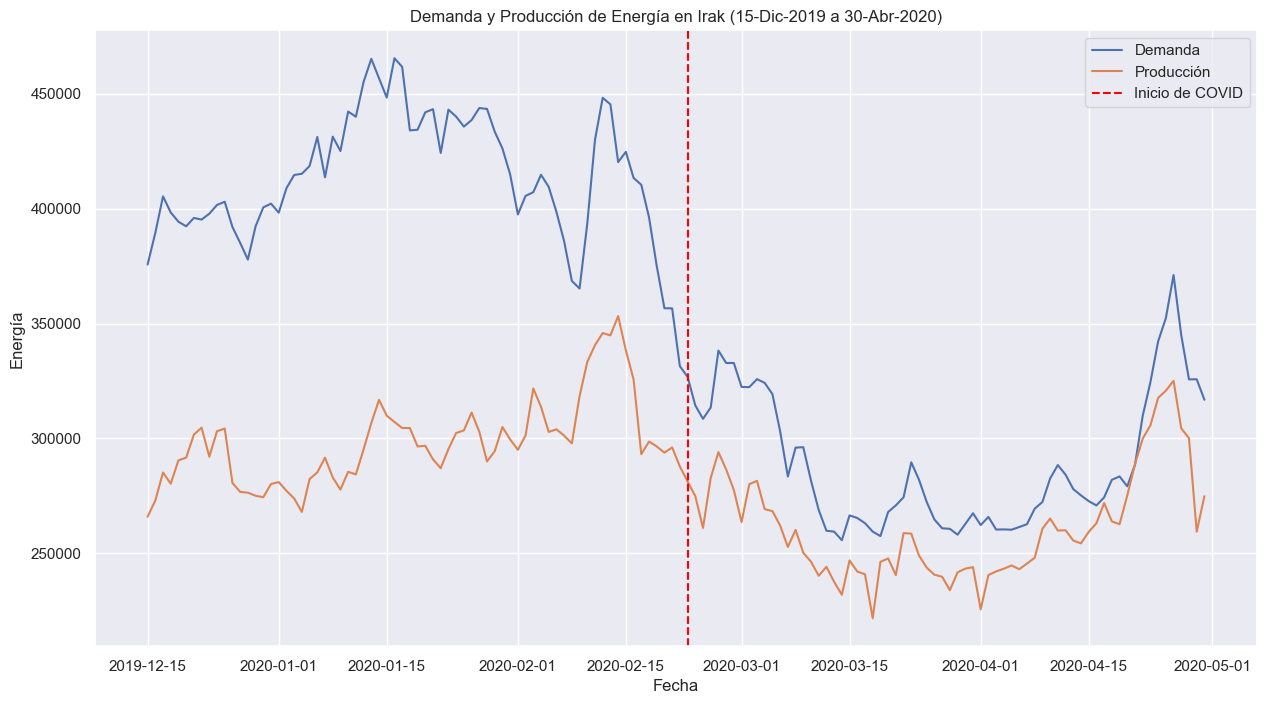

In [61]:
#dos meses antes del covid
data_filtered = data[(data.index >= pd.Timestamp("2019-12-15")) & (data.index <= pd.Timestamp("2020-04-30"))]
plt.figure(figsize=(15, 8))
plt.plot(data_filtered.index, data_filtered['Demanda'], label='Demanda')
plt.plot(data_filtered.index, data_filtered['Produccion'], label='Producción')
plt.axvline(pd.Timestamp("2020-02-23"), color='red', linestyle='--', label='Inicio de COVID')
plt.title('Demanda y Producción de Energía en Irak (15-Dic-2019 a 30-Abr-2020)')
plt.xlabel('Fecha')
plt.ylabel('Energía')
plt.legend()
plt.grid(True)
plt.show()


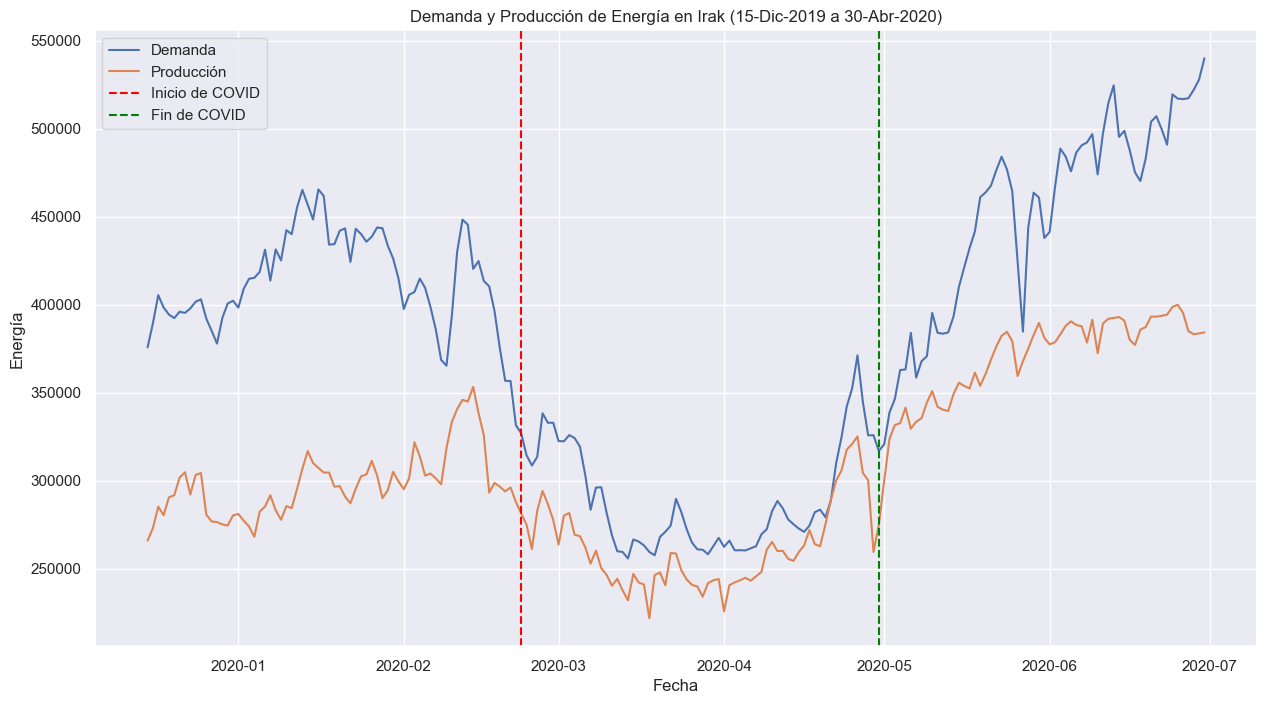

In [62]:
#dos meses antes del covid
data_filtered = data[(data.index >= pd.Timestamp("2019-12-15")) & (data.index <= pd.Timestamp("2020-06-30"))]
plt.figure(figsize=(15, 8))
plt.plot(data_filtered.index, data_filtered['Demanda'], label='Demanda')
plt.plot(data_filtered.index, data_filtered['Produccion'], label='Producción')
plt.axvline(pd.Timestamp("2020-02-23"), color='red', linestyle='--', label='Inicio de COVID')
plt.axvline(pd.Timestamp("2020-04-30"), color='green', linestyle='--', label='Fin de COVID')
plt.title('Demanda y Producción de Energía en Irak (15-Dic-2019 a 30-Abr-2020)')
plt.xlabel('Fecha')
plt.ylabel('Energía')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
media_Covid_precovid = pd.DataFrame() 
datosCovid = {'Periodo': ['Pre-Covid','Covid principio'],
        'Media demanda': [dataPreCovid['Demanda'].mean(), dataCovid['Demanda'].mean()],
        'Media produccion': [dataPreCovid['Produccion'].mean(), dataCovid['Produccion'].mean()]}

media_Covid_precovid = pd.DataFrame(datosCovid)
media_Covid_precovid = media_Covid_precovid.set_index('Periodo')
media_Covid_precovid

Media demanda  Media produccion
Periodo                                         
Pre-Covid        412271.957746     297922.295775
Covid principio  288816.000000     261000.223881

Text(0, 0.5, 'Cuantidad')

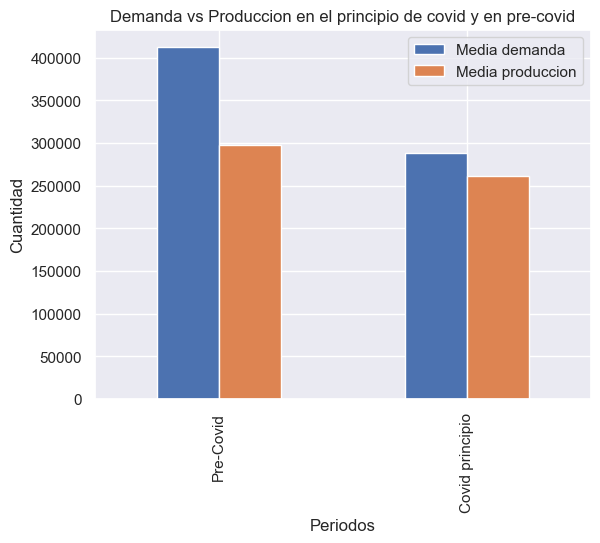

In [64]:
media_Covid_precovid.plot(kind="bar")
plt.title("Demanda vs Produccion en el principio de covid y en pre-covid")
plt.xlabel("Periodos")
plt.ylabel("Cuantidad")

# Festivo nacionales 

In [65]:
dataFestivos = data.copy()
dataFestivos

Demanda  Produccion
fecha                          
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-26   466243      299610
2021-12-27   435243      291977
2021-12-28   420410      279246
2021-12-29   411592      261122
2021-12-30   378184      248905

[1095 rows x 2 columns]

In [66]:
dataEstacion

Demanda  Produccion  estacion
fecha                                    
2019-01-01   379726      289005  Invierno
2019-01-02   383590      288843  Invierno
2019-01-03   378901      283581  Invierno
2019-01-04   378180      285621  Invierno
2019-01-05   385805      283991  Invierno
...             ...         ...       ...
2021-12-26   466243      299610  Invierno
2021-12-27   435243      291977  Invierno
2021-12-28   420410      279246  Invierno
2021-12-29   411592      261122  Invierno
2021-12-30   378184      248905  Invierno

[1095 rows x 3 columns]

In [67]:
# Lista de días festivos
festivos = ["01-jan-2019", "06-jan-2019", "01-may-2019", "14-jul-2019", "03-oct-2019",
            "01-jan-2020", "06-jan-2020", "01-may-2020", "14-jul-2020", "03-oct-2020",
            "01-jan-2021", "06-jan-2021", "01-may-2021", "14-jul-2021", "03-oct-2021"]


# Crear una columna 'Festivo_Nacional' en el DataFrame
dataFestivos['Festivo_Nacional'] = dataFestivos.index.isin(festivos).astype(int)

In [68]:
dataEstacion['Festivo_Nacional'] = dataEstacion.index.isin(festivos)

In [69]:
dataEstacion

Demanda  Produccion  estacion  Festivo_Nacional
fecha                                                      
2019-01-01   379726      289005  Invierno              True
2019-01-02   383590      288843  Invierno             False
2019-01-03   378901      283581  Invierno             False
2019-01-04   378180      285621  Invierno             False
2019-01-05   385805      283991  Invierno             False
...             ...         ...       ...               ...
2021-12-26   466243      299610  Invierno             False
2021-12-27   435243      291977  Invierno             False
2021-12-28   420410      279246  Invierno             False
2021-12-29   411592      261122  Invierno             False
2021-12-30   378184      248905  Invierno             False

[1095 rows x 4 columns]

In [70]:
dataFestivos

Demanda  Produccion  Festivo_Nacional
fecha                                            
2019-01-01   379726      289005                 1
2019-01-02   383590      288843                 0
2019-01-03   378901      283581                 0
2019-01-04   378180      285621                 0
2019-01-05   385805      283991                 0
...             ...         ...               ...
2021-12-26   466243      299610                 0
2021-12-27   435243      291977                 0
2021-12-28   420410      279246                 0
2021-12-29   411592      261122                 0
2021-12-30   378184      248905                 0

[1095 rows x 3 columns]

### Prediccion festivo según solo demanda

In [71]:
def festivo_lstm_demanda(data, look_back):
    #aqui cojo la demanda, he probado otra manera
    features = data[['Demanda']].values

    labels = data['Festivo_Nacional'].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    def create_dataset(X, y, look_back=1):
        Xs, ys = [], []
        for i in range(len(X) - look_back):
            Xs.append(X[i:(i + look_back)])
            ys.append(y[i + look_back])
        return np.array(Xs), np.array(ys)

    X, y = create_dataset(scaled_features, labels, look_back)

    years_train = data.index[look_back:].year < 2021
    years_test = (data.index[look_back:].year == 2021) & (data['Festivo_Nacional'][look_back:] == 1)
    X_train, y_train = X[years_train], y[years_train]
    X_test, y_test = X[years_test], y[years_test]

    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=False, batch_size=32, verbose=1)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred))


In [72]:
festivo_lstm_demanda(dataFestivos, 7)

Epoch 1/20


23/23 [==============================] - 2s 19ms/step - loss: 0.5856 - accuracy: 0.9448 - val_loss: 1.1109 - val_accuracy: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 0s 4ms/step - loss: 0.2748 - accuracy: 0.9890 - val_loss: 3.6107 - val_accuracy: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0764 - accuracy: 0.9890 - val_loss: 6.0265 - val_accuracy: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.9890 - val_loss: 5.4245 - val_accuracy: 0.0000e+00
Epoch 5/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0661 - accuracy: 0.9890 - val_loss: 4.9973 - val_accuracy: 0.0000e+00
Epoch 6/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0650 - accuracy: 0.9890 - val_loss: 4.8823 - val_accuracy: 0.0000e+00
Epoch 7/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.9890 - val_loss: 4.8293 - val_accuracy: 0.0000e+00
Ep

In [73]:
festivo_lstm_demanda(dataFestivos, 30)

Epoch 1/20
22/22 [==============================] - 2s 23ms/step - loss: 0.4967 - accuracy: 0.9429 - val_loss: 2.3535 - val_accuracy: 0.0000e+00
Epoch 2/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0760 - accuracy: 0.9886 - val_loss: 5.0119 - val_accuracy: 0.0000e+00
Epoch 3/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0635 - accuracy: 0.9886 - val_loss: 4.6428 - val_accuracy: 0.0000e+00
Epoch 4/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 4.4243 - val_accuracy: 0.0000e+00
Epoch 5/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4232 - val_accuracy: 0.0000e+00
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 4.4428 - val_accuracy: 0.0000e+00
Epoch 7/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 4.4433 - val_accuracy: 0.

In [74]:
festivo_lstm_demanda(dataFestivos, 100)

Epoch 1/20
20/20 [==============================] - 2s 38ms/step - loss: 0.4678 - accuracy: 0.9873 - val_loss: 2.8638 - val_accuracy: 0.0000e+00
Epoch 2/20
20/20 [==============================] - 0s 23ms/step - loss: 0.0708 - accuracy: 0.9873 - val_loss: 4.7557 - val_accuracy: 0.0000e+00
Epoch 3/20
20/20 [==============================] - 0s 23ms/step - loss: 0.0690 - accuracy: 0.9873 - val_loss: 4.6373 - val_accuracy: 0.0000e+00
Epoch 4/20
20/20 [==============================] - 0s 23ms/step - loss: 0.0684 - accuracy: 0.9873 - val_loss: 4.4178 - val_accuracy: 0.0000e+00
Epoch 5/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3591 - val_accuracy: 0.0000e+00
Epoch 6/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3700 - val_accuracy: 0.0000e+00
Epoch 7/20
20/20 [==============================] - 1s 26ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3794 - val_accura

### Prediccion estaciones según solo produccion

In [75]:
def festivo_lstm_produccion(data, look_back):
    #aqui cojo la produccion, he probado otra manera
    features = data[['Produccion']].values

    labels = data['Festivo_Nacional'].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    def create_dataset(X, y, look_back=1):
        Xs, ys = [], []
        for i in range(len(X) - look_back):
            Xs.append(X[i:(i + look_back)])
            ys.append(y[i + look_back])
        return np.array(Xs), np.array(ys)

    X, y = create_dataset(scaled_features, labels, look_back)

    years_train = data.index[look_back:].year < 2021
    years_test = (data.index[look_back:].year == 2021) & (data['Festivo_Nacional'][look_back:] == 1)
    X_train, y_train = X[years_train], y[years_train]
    X_test, y_test = X[years_test], y[years_test]

    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=False, batch_size=32, verbose=1)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred))


In [76]:
festivo_lstm_produccion(dataFestivos, 7)

Epoch 1/20
23/23 [==============================] - 2s 18ms/step - loss: 0.5867 - accuracy: 0.9006 - val_loss: 1.0740 - val_accuracy: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 0s 4ms/step - loss: 0.2687 - accuracy: 0.9890 - val_loss: 3.0834 - val_accuracy: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0756 - accuracy: 0.9890 - val_loss: 5.3182 - val_accuracy: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0665 - accuracy: 0.9890 - val_loss: 5.0067 - val_accuracy: 0.0000e+00
Epoch 5/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0641 - accuracy: 0.9890 - val_loss: 4.6682 - val_accuracy: 0.0000e+00
Epoch 6/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0633 - accuracy: 0.9890 - val_loss: 4.5693 - val_accuracy: 0.0000e+00
Epoch 7/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0629 - accuracy: 0.9890 - val_loss: 4.5494 - val_accuracy: 0.

In [77]:
festivo_lstm_produccion(dataFestivos, 30)

Epoch 1/20
22/22 [==============================] - 2s 39ms/step - loss: 0.4453 - accuracy: 0.9586 - val_loss: 2.5902 - val_accuracy: 0.0000e+00
Epoch 2/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0691 - accuracy: 0.9886 - val_loss: 4.6032 - val_accuracy: 0.0000e+00
Epoch 3/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0629 - accuracy: 0.9886 - val_loss: 4.6317 - val_accuracy: 0.0000e+00
Epoch 4/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 4.4865 - val_accuracy: 0.0000e+00
Epoch 5/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4410 - val_accuracy: 0.0000e+00
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4438 - val_accuracy: 0.0000e+00
Epoch 7/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4484 - val_accuracy: 0.

In [78]:
festivo_lstm_produccion(dataFestivos, 100)

Epoch 1/20
20/20 [==============================] - 2s 39ms/step - loss: 0.4156 - accuracy: 0.9873 - val_loss: 3.0903 - val_accuracy: 0.0000e+00
Epoch 2/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0690 - accuracy: 0.9873 - val_loss: 4.6542 - val_accuracy: 0.0000e+00
Epoch 3/20
20/20 [==============================] - 0s 23ms/step - loss: 0.0686 - accuracy: 0.9873 - val_loss: 4.5443 - val_accuracy: 0.0000e+00
Epoch 4/20
20/20 [==============================] - 0s 23ms/step - loss: 0.0683 - accuracy: 0.9873 - val_loss: 4.3842 - val_accuracy: 0.0000e+00
Epoch 5/20
20/20 [==============================] - 0s 24ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3587 - val_accuracy: 0.0000e+00
Epoch 6/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3733 - val_accuracy: 0.0000e+00
Epoch 7/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3786 - val_accura

### Prediccion estaciones ambas características

In [79]:
def festivos_LSTM(data, look_back):
    features = data[['Produccion', 'Demanda']].values
    labels = data['Festivo_Nacional'].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    def create_dataset(X, y, look_back=1):
        Xs, ys = [], []
        for i in range(len(X) - look_back):
            Xs.append(X[i:(i + look_back)])
            ys.append(y[i + look_back])
        return np.array(Xs), np.array(ys)

    X, y = create_dataset(scaled_features, labels, look_back)

    years_train = data.index[look_back:].year < 2021
    years_test = (data.index[look_back:].year == 2021) & (data['Festivo_Nacional'][look_back:] == 1)

    X_train = X[years_train]
    y_train = y[years_train]
    X_test = X[years_test]
    y_test = y[years_test]

    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, shuffle=False, batch_size=32, verbose=1)
       
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(classification_report(y_test, y_pred))


In [80]:
festivos_LSTM(dataFestivos, 7)

Epoch 1/20
23/23 [==============================] - 2s 17ms/step - loss: 0.5325 - accuracy: 0.9890 - val_loss: 1.3744 - val_accuracy: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 0s 3ms/step - loss: 0.1883 - accuracy: 0.9890 - val_loss: 4.2888 - val_accuracy: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0716 - accuracy: 0.9890 - val_loss: 5.5882 - val_accuracy: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0671 - accuracy: 0.9890 - val_loss: 5.1810 - val_accuracy: 0.0000e+00
Epoch 5/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.9890 - val_loss: 4.8525 - val_accuracy: 0.0000e+00
Epoch 6/20
23/23 [==============================] - 0s 4ms/step - loss: 0.0638 - accuracy: 0.9890 - val_loss: 4.7175 - val_accuracy: 0.0000e+00
Epoch 7/20
23/23 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.9890 - val_loss: 4.6565 - val_accuracy: 0.

In [81]:
festivos_LSTM(dataFestivos, 30)

Epoch 1/20
22/22 [==============================] - 2s 23ms/step - loss: 0.4805 - accuracy: 0.9116 - val_loss: 2.0481 - val_accuracy: 0.0000e+00
Epoch 2/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0864 - accuracy: 0.9886 - val_loss: 4.6616 - val_accuracy: 0.0000e+00
Epoch 3/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0632 - accuracy: 0.9886 - val_loss: 4.6376 - val_accuracy: 0.0000e+00
Epoch 4/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 4.4343 - val_accuracy: 0.0000e+00
Epoch 5/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 4.4220 - val_accuracy: 0.0000e+00
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 4.4395 - val_accuracy: 0.0000e+00
Epoch 7/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0626 - accuracy: 0.9886 - val_loss: 4.4399 - val_accuracy: 0.

In [82]:
festivos_LSTM(dataFestivos, 100)

Epoch 1/20
20/20 [==============================] - 2s 38ms/step - loss: 0.5039 - accuracy: 0.8922 - val_loss: 2.0179 - val_accuracy: 0.0000e+00
Epoch 2/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0836 - accuracy: 0.9873 - val_loss: 4.4820 - val_accuracy: 0.0000e+00
Epoch 3/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0684 - accuracy: 0.9873 - val_loss: 4.6059 - val_accuracy: 0.0000e+00
Epoch 4/20
20/20 [==============================] - 0s 23ms/step - loss: 0.0684 - accuracy: 0.9873 - val_loss: 4.4300 - val_accuracy: 0.0000e+00
Epoch 5/20
20/20 [==============================] - 0s 22ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3645 - val_accuracy: 0.0000e+00
Epoch 6/20
20/20 [==============================] - 0s 23ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3684 - val_accuracy: 0.0000e+00
Epoch 7/20
20/20 [==============================] - 0s 24ms/step - loss: 0.0681 - accuracy: 0.9873 - val_loss: 4.3771 - val_accura

# Análisis de festivos 

In [83]:
Festivos_Nacionales = ["01-jan-2019" ,"06-jan-2019","01-may-2019","14-jul-2019","03-oct-2019","01-jan-2020" ,"06-jan-2020","01-may-2020","14-jul-2020","03-oct-2020","01-jan-2021" ,"06-jan-2021","01-may-2021","14-jul-2021","03-oct-2021"]
Festivos_Nacionales


['01-jan-2019',
 '06-jan-2019',
 '01-may-2019',
 '14-jul-2019',
 '03-oct-2019',
 '01-jan-2020',
 '06-jan-2020',
 '01-may-2020',
 '14-jul-2020',
 '03-oct-2020',
 '01-jan-2021',
 '06-jan-2021',
 '01-may-2021',
 '14-jul-2021',
 '03-oct-2021']

In [84]:
dataFestivo = data[data.index.isin(Festivos_Nacionales)]
dataFestivo


Demanda  Produccion
fecha                          
2019-01-01   379726      289005
2019-01-06   378280      278314
2019-05-01   323099      262720
2019-07-14   493512      412650
2019-10-03   461922      375271
2020-01-01   398283      281007
2020-01-06   431218      285232
2020-05-01   320559      299753
2020-07-14   579399      400581
2020-10-03   431841      378241
2021-01-01   398854      249832
2021-01-06   406022      256305
2021-05-01   397250      339273
2021-07-14   608133      439941
2021-10-03   397250      273672

<Axes: xlabel='fecha'>

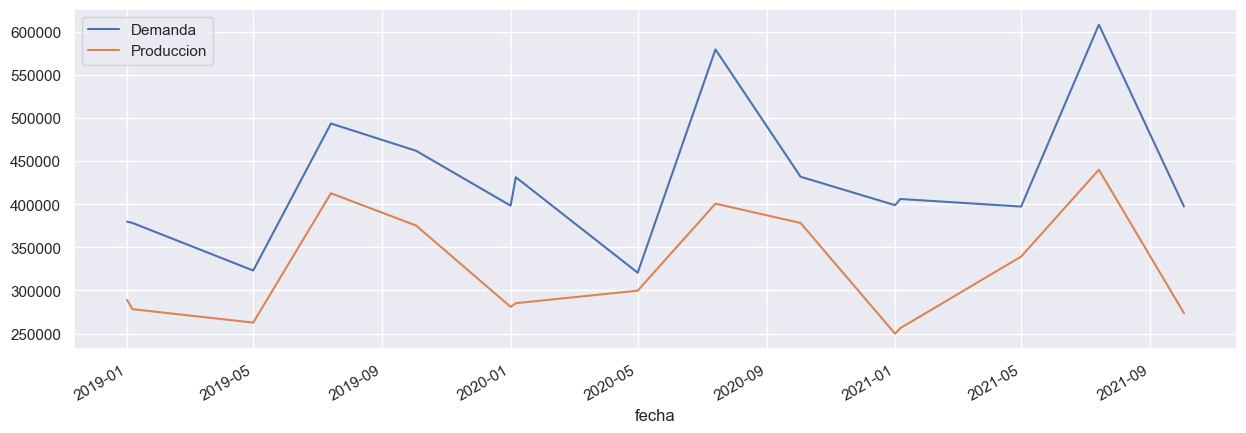

In [85]:
dataFestivo.plot(figsize=(15,5))

Text(0, 0.5, 'Energís(MW)')

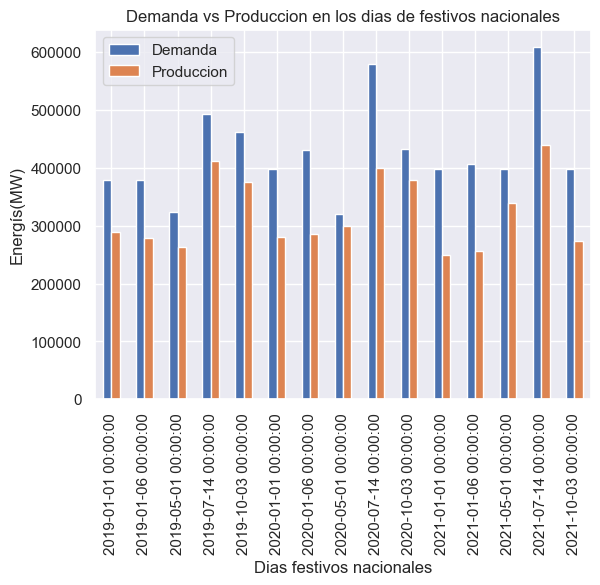

In [86]:
dataFestivo.plot(kind="bar")
plt.title("Demanda vs Produccion en los dias de festivos nacionales")
plt.xlabel("Dias festivos nacionales")
plt.ylabel("Energís(MW)")

In [87]:
dataTemporadasProduccion = dataEstacion.groupby('estacion').agg(media_produccion=('Produccion','mean')).reset_index()
dataTemporadasProduccion

estacion  media_produccion
0   Invierno     268132.415978
1      Otoño     283917.808743
2  Primavera     306742.420765
3     Verano     403776.814208

In [88]:
dataTemporadasDemanda = dataEstacion.groupby('estacion').agg(media_Demanda=('Demanda','mean')).reset_index()
dataTemporadasDemanda

estacion  media_Demanda
0   Invierno  367675.931129
1      Otoño  342338.863388
2  Primavera  365714.278689
3     Verano  540844.855191

In [89]:
dataTemporadas = pd.merge(dataTemporadasDemanda, dataTemporadasProduccion, on='estacion')
dataTemporadas = dataTemporadas.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})
dataTemporadas = dataTemporadas.set_index('estacion')
dataTemporadas

media_Demanda  media_produccion
estacion                                  
Invierno   367675.931129     268132.415978
Otoño      342338.863388     283917.808743
Primavera  365714.278689     306742.420765
Verano     540844.855191     403776.814208

Text(0, 0.5, 'Capacidad media')

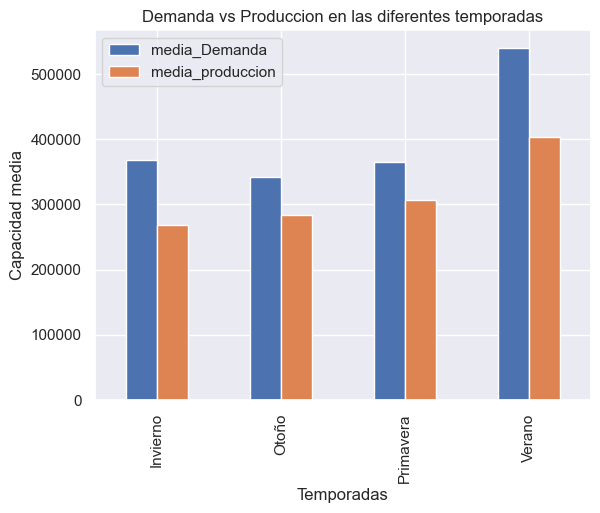

In [90]:
dataTemporadas.plot(kind="bar")
plt.title("Demanda vs Produccion en las diferentes temporadas")
plt.xlabel("Temporadas")
plt.ylabel("Capacidad media")

# Shaaban vs  Ramadan

In [91]:
data_shaaban_ramadan = data.copy()

In [92]:
data_shaaban_ramadan

Demanda  Produccion
fecha                          
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-26   466243      299610
2021-12-27   435243      291977
2021-12-28   420410      279246
2021-12-29   411592      261122
2021-12-30   378184      248905

[1095 rows x 2 columns]

In [93]:
date_index = pd.date_range(start="01-01-2019", periods=len(data_shaaban_ramadan), freq='D')
data_shaaban_ramadan.index = date_index

In [94]:
data_shaaban_ramadan

Demanda  Produccion
2019-01-01   379726      289005
2019-01-02   383590      288843
2019-01-03   378901      283581
2019-01-04   378180      285621
2019-01-05   385805      283991
...             ...         ...
2021-12-26   466243      299610
2021-12-27   435243      291977
2021-12-28   420410      279246
2021-12-29   411592      261122
2021-12-30   378184      248905

[1095 rows x 2 columns]

In [95]:
periodos = pd.Series(0, index=data_shaaban_ramadan.index)
periodos[(pd.to_datetime("06-may-2019") <= periodos.index) & (periodos.index <= pd.to_datetime("04-jun-2019"))] = 1
periodos[(pd.to_datetime("06-apr-2019") <= periodos.index) & (periodos.index <= pd.to_datetime("05-may-2019"))] = 1
periodos[(pd.to_datetime("24-apr-2020") <= periodos.index) & (periodos.index <= pd.to_datetime("23-may-2020"))] = 1
periodos[(pd.to_datetime("25-mar-2020") <= periodos.index) & (periodos.index <= pd.to_datetime("23-apr-2020"))] = 1
periodos[(pd.to_datetime("13-apr-2021") <= periodos.index) & (periodos.index <= pd.to_datetime("12-may-2021"))] = 1
periodos[(pd.to_datetime("14-mar-2021") <= periodos.index) & (periodos.index <= pd.to_datetime("12-apr-2021"))] = 1
data_shaaban_ramadan['periodo'] = periodos

In [96]:
features = ['Demanda', 'Produccion', 'periodo']
train_data = data_shaaban_ramadan[features]['2019-01-01':'2020-12-31']
valid_data = data_shaaban_ramadan[features]['2021-01-01':]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
valid_scaled = scaler.transform(valid_data)

In [97]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), :-1])
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

In [98]:
look_back = 100
X_train, y_train = create_dataset(train_scaled, look_back)
X_valid, y_valid = create_dataset(valid_scaled, look_back)

In [99]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

Epoch 1/50


20/20 - 4s - loss: 0.6224 - accuracy: 0.6355 - val_loss: 0.3615 - val_accuracy: 0.8788 - 4s/epoch - 204ms/step
Epoch 2/50
20/20 - 1s - loss: 0.4554 - accuracy: 0.8177 - val_loss: 0.2913 - val_accuracy: 0.8788 - 1s/epoch - 55ms/step
Epoch 3/50
20/20 - 1s - loss: 0.4218 - accuracy: 0.8177 - val_loss: 0.2797 - val_accuracy: 0.8788 - 1s/epoch - 52ms/step
Epoch 4/50
20/20 - 1s - loss: 0.3817 - accuracy: 0.8177 - val_loss: 0.2470 - val_accuracy: 0.8788 - 1s/epoch - 54ms/step
Epoch 5/50
20/20 - 1s - loss: 0.3647 - accuracy: 0.8177 - val_loss: 0.2042 - val_accuracy: 0.8788 - 1s/epoch - 51ms/step
Epoch 6/50
20/20 - 1s - loss: 0.4882 - accuracy: 0.8177 - val_loss: 0.2638 - val_accuracy: 0.8788 - 1s/epoch - 55ms/step
Epoch 7/50
20/20 - 1s - loss: 0.3570 - accuracy: 0.8003 - val_loss: 0.2438 - val_accuracy: 0.8788 - 1s/epoch - 52ms/step
Epoch 8/50
20/20 - 1s - loss: 0.3340 - accuracy: 0.8177 - val_loss: 0.1761 - val_accuracy: 0.8788 - 1s/epoch - 51ms/step
Epoch 9/50
20/20 - 1s - loss: 0.2989 - acc

In [100]:
y_pred_probs = model.predict(X_valid)
y_pred = (y_pred_probs > 0.6).astype(int).flatten()

9/9 [==============================] - 1s 16ms/step


In [101]:
real_days = y_valid[y_valid == 1]
predicted_days = y_pred[y_valid == 1]
accuracy = accuracy_score(real_days, predicted_days)
print(f"Accuracy: {accuracy * 100:.2f}%")
report = classification_report(real_days, predicted_days)
print(report)

Accuracy: 81.25%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.81      0.90        32

    accuracy                           0.81        32
   macro avg       0.50      0.41      0.45        32
weighted avg       1.00      0.81      0.90        32



# Análisis exploratorio del Ramadan y el Shaa'ban

In [102]:
#2019
dataRamadan2019 = data[pd.to_datetime("06-may-2019") <= data.index ]
dataRamadan2019  = dataRamadan2019[dataRamadan2019.index <= pd.to_datetime("04-jun-2019")]

dataShaaban2019 = data[pd.to_datetime("06-apr-2019") <= data.index ]
dataShaaban2019  = dataShaaban2019[dataShaaban2019.index <= pd.to_datetime("05-may-2019")]

#2020
dataRamadan2020 = data[pd.to_datetime("24-apr-2020") <= data.index ]
dataRamadan2020  = dataRamadan2020[dataRamadan2020.index <= pd.to_datetime("23-may-2020")]

dataShaaban2020 = data[pd.to_datetime("25-mar-2020") <= data.index ]
dataShaaban2020  = dataShaaban2020[dataShaaban2020.index <= pd.to_datetime("23-apr-2020")]

#2021
dataRamadan2021 = data[pd.to_datetime("13-apr-2021") <= data.index ]
dataRamadan2021  = dataRamadan2021[dataRamadan2021.index <= pd.to_datetime("12-may-2021")]

dataShaaban2021 = data[pd.to_datetime("14-mar-2021") <= data.index ]
dataShaaban2021  = dataShaaban2021[dataShaaban2021.index <= pd.to_datetime("12-apr-2021")]


In [103]:
media_Chaaban_Ramadan = pd.DataFrame() 
datos = {'Epoca': ['Shaaban 2019','Ramadan 2019' ,'Shaaban 2020','Ramadan 2020', 'Shaaban 2021','Ramadan 2021'],
        'Media demanda': [dataShaaban2019['Demanda'].mean(), dataRamadan2019['Demanda'].mean(), dataShaaban2020['Demanda'].mean(), dataRamadan2020['Demanda'].mean(), dataShaaban2021['Demanda'].mean(),dataRamadan2021['Demanda'].mean()],
        'Media produccion': [dataShaaban2019['Produccion'].mean(), dataRamadan2019['Produccion'].mean(), dataShaaban2020['Produccion'].mean(), dataRamadan2020['Produccion'].mean(), dataShaaban2021['Produccion'].mean(),dataRamadan2021['Produccion'].mean()]}

media_Shaaban_Ramadan = pd.DataFrame(datos)
media_Shaaban_Ramadan = media_Shaaban_Ramadan.set_index('Epoca')
media_Shaaban_Ramadan

Media demanda  Media produccion
Epoca                                        
Shaaban 2019  286469.000000     238806.866667
Ramadan 2019  395727.033333     357752.066667
Shaaban 2020  273865.533333     255552.966667
Ramadan 2020  386320.000000     335347.600000
Shaaban 2021  288550.200000     240607.533333
Ramadan 2021  400432.066667     314738.500000

Text(0, 0.5, 'Media')

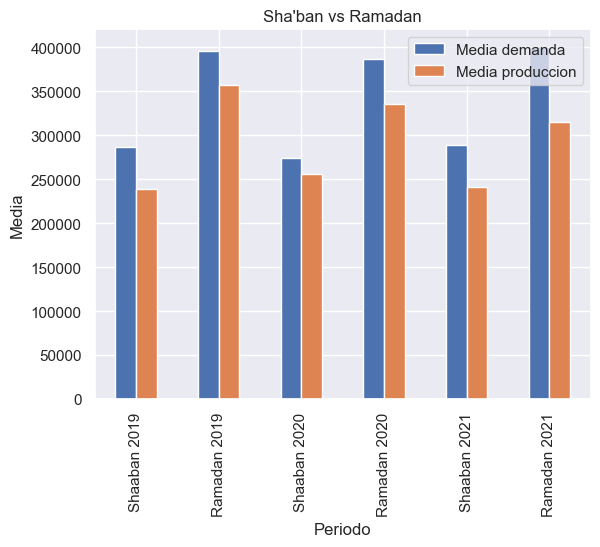

In [104]:
media_Shaaban_Ramadan.plot(kind="bar")
plt.title("Sha'ban vs Ramadan")
plt.xlabel("Periodo")
plt.ylabel("Media")

In [105]:
data.describe()

Demanda     Produccion
count    1095.000000    1095.000000
mean   420994.799087  322561.829224
std    108713.245473   69567.326734
min    234522.000000  187266.000000
25%    325740.000000  258997.500000
50%    411592.000000  303169.000000
75%    498163.500000  391964.000000
max    664606.000000  453020.000000

Ya de primera podemos observar que vamos a tener dias donde la demanda supera a la produccion, y ademas de media siempre vamos a tener mayor demanda que produccion

In [106]:
dataMes= data.resample('m').sum()
dataMes

Demanda  Produccion
fecha                           
2019-01-31  12344034     8892026
2019-02-28  10327355     7753904
2019-03-31   9566047     7603419
2019-04-30   8329040     6860510
2019-05-31  11823599    10597214
2019-06-30  14146614    11740792
2019-07-31  15465729    12511220
2019-08-31  15627938    12676743
2019-09-30  14477503    11977411
2019-10-31  11810422     9998288
2019-11-30   7949894     7243726
2019-12-31  11446699     8653209
2020-01-31  13489781     9110785
2020-02-29  11022374     8862696
2020-03-31   8662324     7728448
2020-04-30   8747987     8081607
2020-05-31  12767656    10977659
2020-06-30  14905798    11627558
2020-07-31  18199501    12252714
2020-08-31  17827320    12969990
2020-09-30  16403785    12160900
2020-10-31  10320331     9483095
2020-11-30   8397757     7106362
2020-12-31  11644426     7536600
2021-01-31  13005501     8091202
2021-02-28  10390139     7253635
2021-03-31   9342708     7317690
2021-04-30  10272893     8450198
2021-05-31  14984538    11166675
2021-06-30  16670675    11921123
2021-07-31  19392643    13231958
2021-08-31  19935514    13392505
2021-09-30  14896197    11319400
2021-10-31  14652679    10581169
2021-11-30   9516929     7544319
2021-12-31  12224975     8528453

In [107]:
dataAno = data.resample('y').sum()
dataAno

Demanda  Produccion
fecha                            
2019-12-31  143314874   116508462
2020-12-31  152389040   117898414
2021-12-31  165285391   118798327

<Axes: xlabel='fecha'>

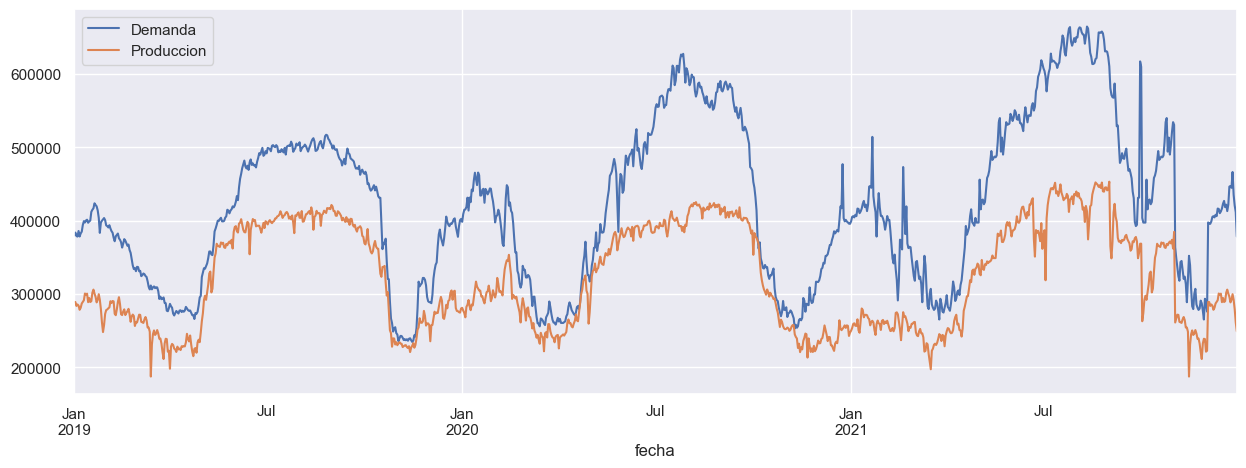

In [108]:
data.plot(figsize=(15,5))

<Axes: >

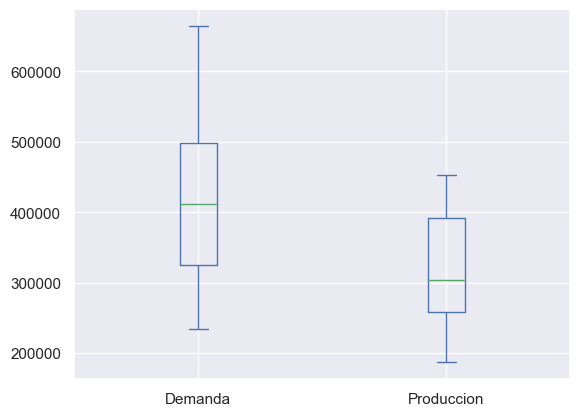

In [109]:
data.plot.box()

Vemos que la produccion nunca abaste la demanda, ademas nos fijamos que en los meses de verano siempre tenemos un pico de demanda que ademas aumenta con los años mientras que la produccion de mantiene

# Dickey-fuller

Vamos a pasar a comprobar si nuestra serie de tiempo es estacionario o no. Para ello vamos a seguir el modelo Dickey-Fuller

In [110]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviacion estandar')
    plt.legend(loc='best')
    plt.title('Media móvil & Desviacion estandar')
    plt.show(block=False)
    
    print ('Resultados del Dickey-Fuller Test:')
   
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de prueba','p-value','#Lags Used','Numero de observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Valores criticos (%s)'%key] = value
    print(dfoutput)

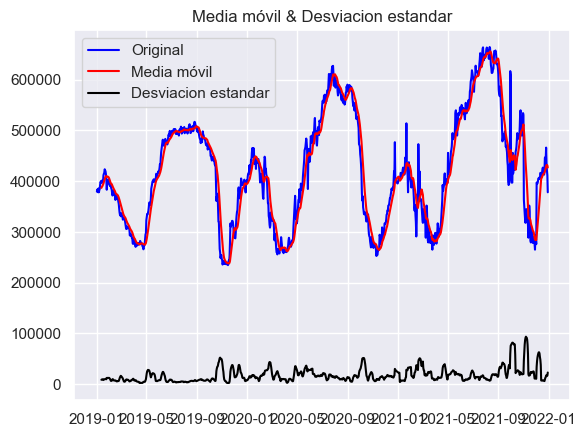

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -3.080073
p-value                       0.028063
#Lags Used                   16.000000
Numero de observaciones    1078.000000
Valores criticos (1%)        -3.436431
Valores criticos (5%)        -2.864225
Valores criticos (10%)       -2.568200
dtype: float64


In [111]:
adfullerDemanda = test_stationarity(data['Demanda'])

Según estos resultados vemos observamos que podemos afirmar que al demanda es estacionario por diversos motivos, el p-value nos indica que tenemos una probabilidad muy baja del 2.68% de que los resultados observados en la serie de tiempo se deban al azar que nos indica que podemos rechazar la hipotesis nula. Luego el estadístico de prueba es menor que los valores críticos para los niveles de significación de 1% y 5% y no difiere mucho del 10% por lo que volvemos a rechazar la hipotesis nula. 

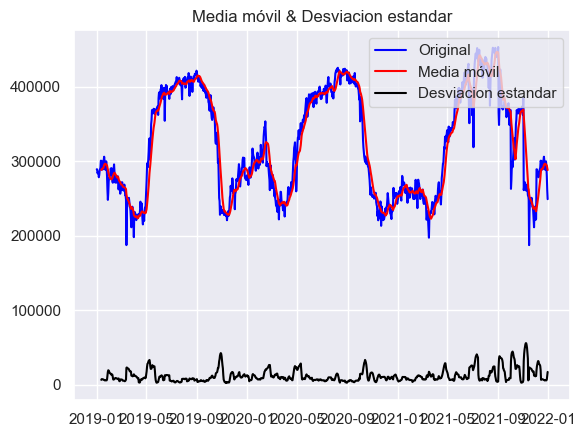

Resultados del Dickey-Fuller Test:
Estadístico de prueba        -2.022303
p-value                       0.276880
#Lags Used                    4.000000
Numero de observaciones    1090.000000
Valores criticos (1%)        -3.436364
Valores criticos (5%)        -2.864195
Valores criticos (10%)       -2.568184
dtype: float64


In [112]:
adfullerProduccion = test_stationarity(data['Produccion'])

Con la produccion vemos que ocurre todo lo contrario, el p-value es mayor que el valor de significancia del 0,05 y ademas nuestro estadistico de prueba es mayor que todos los valores criticos. Por lo cual decidimos que la serie de tiempo no es estacionaria.

# ARIMA 1

Sabiendo que la demanda si es estacionaria, vamos a aplicarle un modelo de  regresion autorregresiva integrada de media movil (ARIMA)

In [113]:
dataArima= dataMes['Demanda'].copy()


In [114]:
train_data_arima = dataArima[:int(len(dataArima)*0.8)].copy()
test_data_arima = dataArima[int(len(dataArima)*0.8):].copy()


In [115]:
def modelo_arima(p,d,q):
    model = ARIMA(train_data_arima, order=(p,d,q))
    model_fit = model.fit()
    print(model_fit.summary())

In [116]:
modelo_arima(1,1,1)
modelo_arima(2,1,1)
modelo_arima(2,1,2)


                               SARIMAX Results                                
Dep. Variable:                Demanda   No. Observations:                   28
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -436.052
Date:                Sun, 29 Oct 2023   AIC                            878.104
Time:                        19:04:59   BIC                            881.991
Sample:                    01-31-2019   HQIC                           879.260
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      1.231     -0.177      0.860      -2.631       2.196
ma.L1          0.3382      1.249      0.271      0.787      -2.109       2.786
sigma2      5.968e+12   4.28e-13   1.39e+25      0.0

Vamos a probar con una funcion que nos saca lo mejores valores

Vemos que el mejor AIC lo tiene el modelo para los valores (2,1,2)

In [117]:
modelfinal = ARIMA(train_data_arima, order=(2, 1, 2))
model_fit1 = modelfinal.fit()

In [118]:
forecast = model_fit1.forecast(steps=10)[0]

In [119]:
print(forecast)

11083104.83548585


In [120]:
predicciones = model_fit1.predict(start=len(train_data_arima), end=len(dataArima)-1, typ='levels')
predicciones

2021-05-31    1.108310e+07
2021-06-30    1.302890e+07
2021-07-31    1.414135e+07
2021-08-31    1.331579e+07
2021-09-30    1.140825e+07
2021-10-31    1.034849e+07
2021-11-30    1.118809e+07
2021-12-31    1.305749e+07
Freq: M, Name: predicted_mean, dtype: float64

In [121]:
errorARIMA = np.mean(np.abs((test_data_arima - predicciones) / test_data_arima)) * 100
accuracyARIMA = 100 - errorARIMA
mseARIMA = mean_squared_error(test_data_arima, predicciones)

In [122]:
print(f"Precision modelo ARIMA es: {accuracyARIMA}" )
print(f"El error es: {errorARIMA}")
print(f"El error cuadrático mse: {mseARIMA} kw")

Precision modelo ARIMA es: 76.83426026088317
El error es: 23.165739739116827
El error cuadrático mse: 16757275986563.992 kw


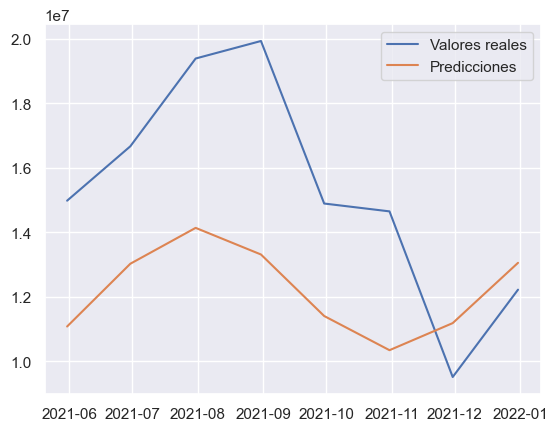

In [123]:
plt.plot(dataArima.index[int(len(dataArima)*0.8):], test_data_arima, label='Valores reales')
plt.plot(dataArima.index[int(len(dataArima)*0.8):], predicciones, label='Predicciones')
plt.legend()
plt.show()

# ARIMA 2

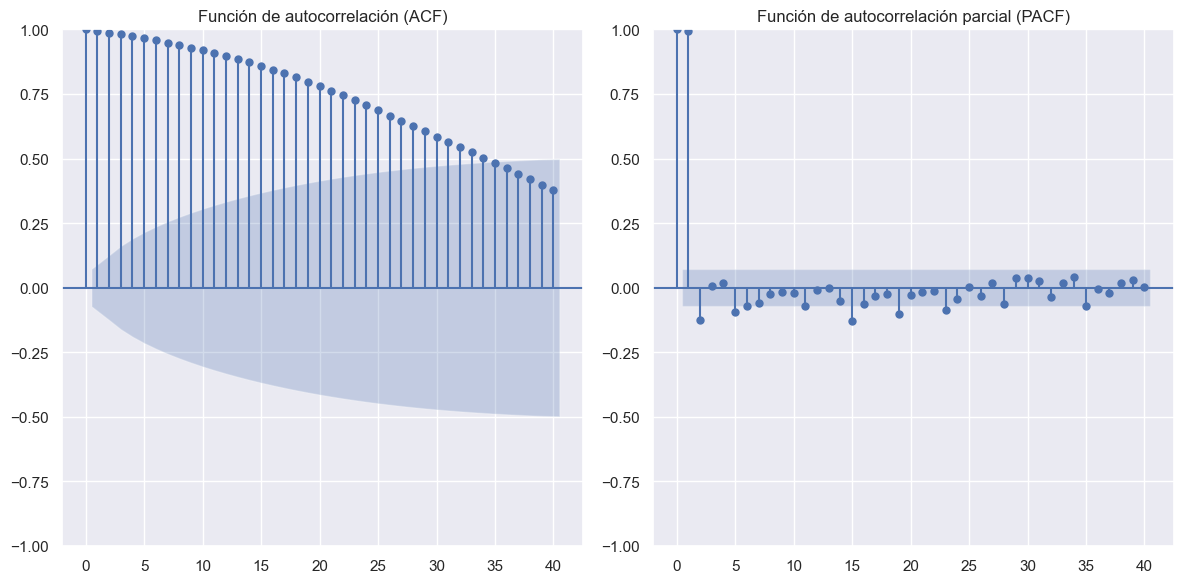

In [124]:
dataArima = data['Demanda'].copy()

train_data_arima = dataArima['2019-01-01':'2020-12-31'].copy()
test_data_arima = dataArima['2021-01-01':'2021-12-31'].copy()

def modelo_arima(p, d, q):
    model = ARIMA(train_data_arima, order=(p, d, q))
    model_fit = model.fit()
    print(model_fit.summary())
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_data_arima, lags=40, ax=plt.gca())
plt.title('Función de autocorrelación (ACF)')
plt.subplot(122)
plot_pacf(train_data_arima, lags=40, ax=plt.gca())
plt.title('Función de autocorrelación parcial (PACF)')
plt.tight_layout()
plt.show()




In [125]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
aic_values = []
for param in pdq:
    try:
        model = ARIMA(train_data_arima, order=param)
        model_fit = model.fit()
        aic_values.append((param, model_fit.aic))
    except:
        continue
best_param = min(aic_values, key=lambda x: x[1])
best_param

((1, 1, 2), 15590.235245388129)

In [197]:
modelo_arima(1, 1, 2)


                               SARIMAX Results                                
Dep. Variable:                Demanda   No. Observations:                  731
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -7791.118
Date:                Sat, 09 Sep 2023   AIC                          15590.235
Time:                        00:37:36   BIC                          15608.607
Sample:                    01-01-2019   HQIC                         15597.323
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9433      0.057     16.561      0.000       0.832       1.055
ma.L1         -0.8972      0.057    -15.795      0.000      -1.009      -0.786
ma.L2         -0.0272      0.019     -1.403      0.1

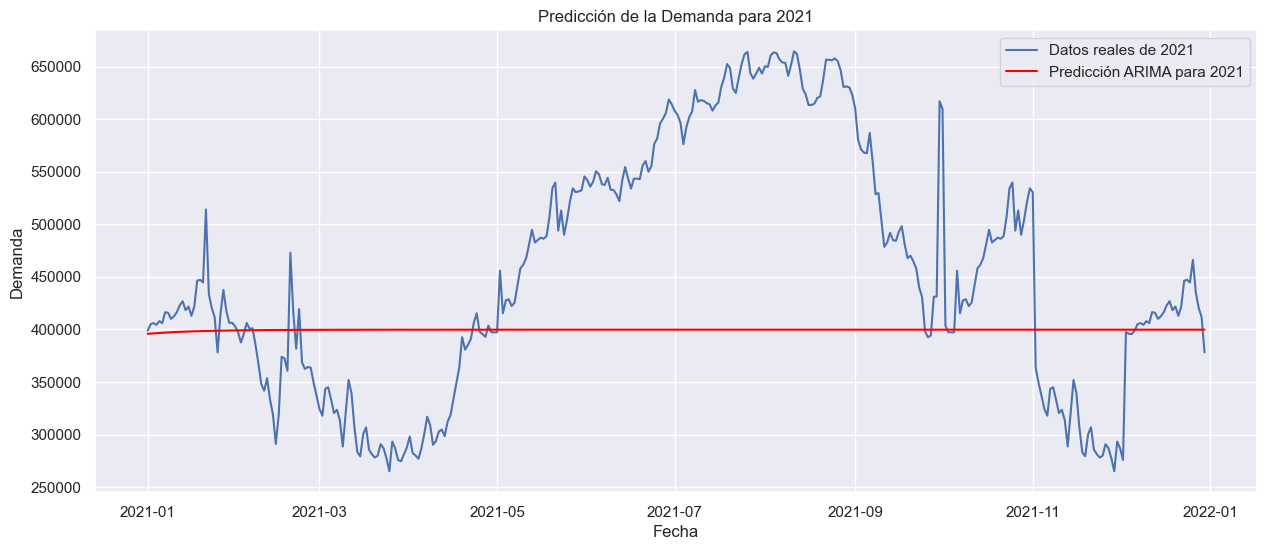

In [127]:
model = ARIMA(train_data_arima, order=(1, 1, 2))
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=len(test_data_arima))
forecast_mean = forecast.predicted_mean
plt.figure(figsize=(15, 6))
plt.plot(test_data_arima.index, test_data_arima, label='Datos reales de 2021')
plt.plot(test_data_arima.index, forecast_mean, label='Predicción ARIMA para 2021', color='red')
plt.title('Predicción de la Demanda para 2021')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()


# LSTM por días con ambas características

Estudiando un poco la relación que existe entre la demanda y la produccion encontramos que esta última siempre va a estar condicionada por la demanda ya que no se puede dar el caso de que la produccion sea mayor que la demanda. Vamos a aplicar un modelo de Deep learning conocido como Redes neuronales recurrentes(RNN), las cuales cuentan con "memoria". Usaremos de tipo LSTM, con dos capas LSTM de 50 unidades, una Dense con una única salida y el optimizador Adam, que para este tipo de series temporales es el mas adecuado

In [198]:
dataRNNdias = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdias), freq='D')
dataRNNdias.index = date_index

### LSTM para predececir la demanda

In [199]:
def LSTMDemandaDiarioDosCaracteristicas(time_steps, data):
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Demanda']]
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]
    
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # visualización
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo el día anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 2s 13ms/step - loss: 0.2214 - val_loss: 0.3115
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 0.1487 - val_loss: 0.1858
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0593 - val_loss: 0.0420
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0202 - val_loss: 0.0181
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0165 - val_loss: 0.0194
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0130 - val_loss: 0.0142
Epoch 7/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0122
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0097
Epoch 9/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0089
Epoch 10/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0086
Epoch 11/50
23/23 

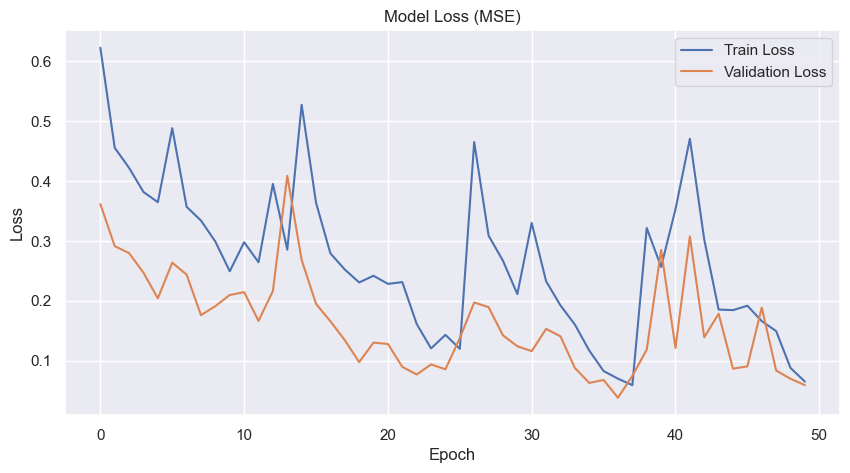

12/12 [==============================] - 0s 818us/step
     Real Values   Predictions
0         405037  396031.18750
1         406001  400892.34375
2         404353  402272.56250
3         407859  401218.46875
4         406022  403314.37500
..           ...           ...
361       411592  415493.78125
362       378184  406608.78125
363       414996  381623.65625
364       437452  408631.90625
365       417780  427567.34375

[366 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 21.58%


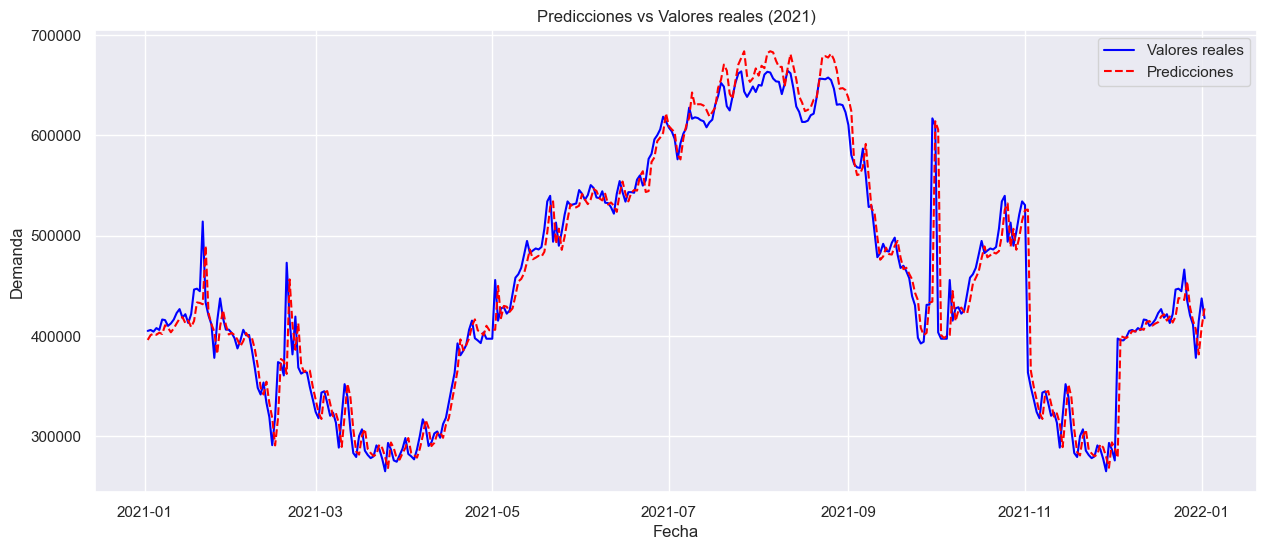

In [200]:
LSTMDemandaDiarioDosCaracteristicas(1, dataRNNdias)

    Cogiendo la semana anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 2s 17ms/step - loss: 0.2108 - val_loss: 0.2127
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0431 - val_loss: 0.0149
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0115 - val_loss: 0.0101
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0067 - val_loss: 0.0108
Epoch 5/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0124
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0111
Epoch 7/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0103
Epoch 8/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0097
Epoch 9/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0094
Epoch 10/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0091
Epoch 11/50
23/23 

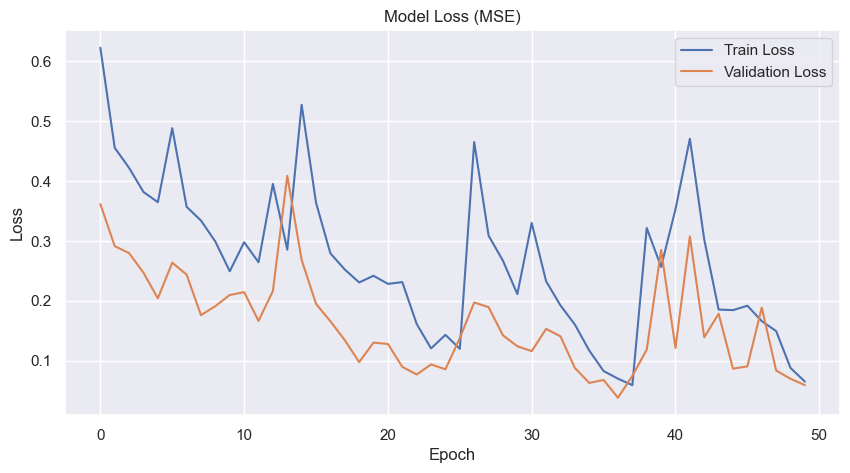

12/12 [==============================] - 0s 2ms/step
     Real Values   Predictions
0         415824  417085.78125
1         410048  419828.84375
2         412486  416036.25000
3         416401  417289.28125
4         422912  424621.12500
..           ...           ...
355       411592  432484.15625
356       378184  414494.09375
357       414996  393418.93750
358       437452  386886.28125
359       417780  406191.34375

[360 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 21.94%


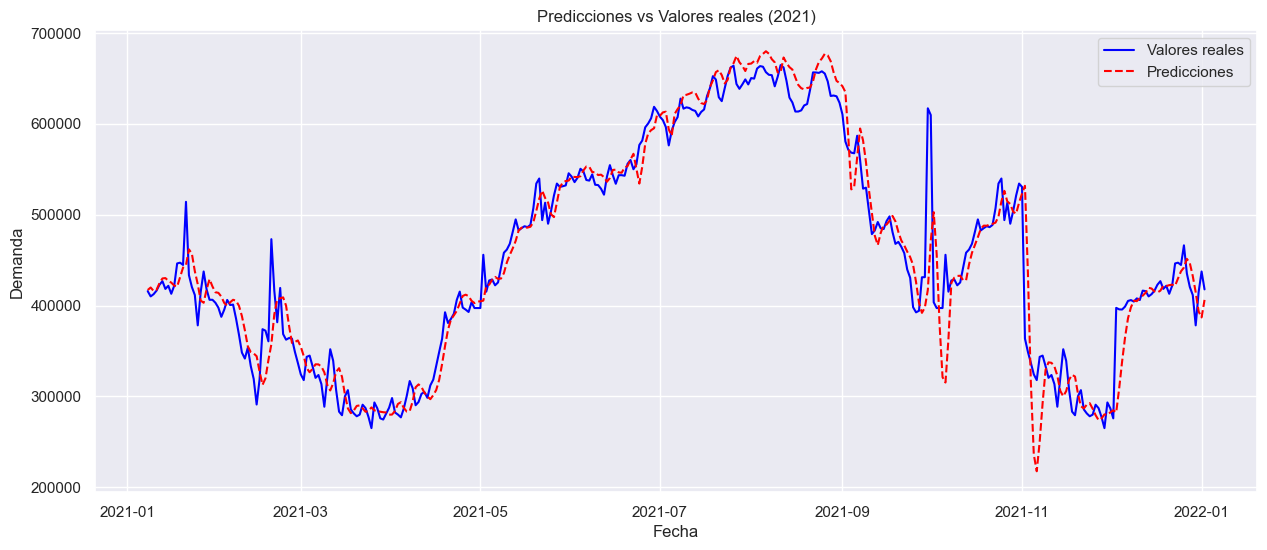

In [201]:
LSTMDemandaDiarioDosCaracteristicas(7, dataRNNdias)

    Cogiendo 30 dias anterior anterior para la prediccion

Epoch 1/50
22/22 [==============================] - 2s 34ms/step - loss: 0.1037 - val_loss: 0.0175
Epoch 2/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0165 - val_loss: 0.0162
Epoch 3/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0122 - val_loss: 0.0162
Epoch 4/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0101 - val_loss: 0.0170
Epoch 5/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0087 - val_loss: 0.0148
Epoch 6/50
22/22 [==============================] - 1s 24ms/step - loss: 0.0069 - val_loss: 0.0128
Epoch 7/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 8/50
22/22 [==============================] - 1s 24ms/step - loss: 0.0039 - val_loss: 0.0113
Epoch 9/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0035 - val_loss: 0.0107
Epoch 10/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0029 - val_loss: 0.0098
Epoch 11/

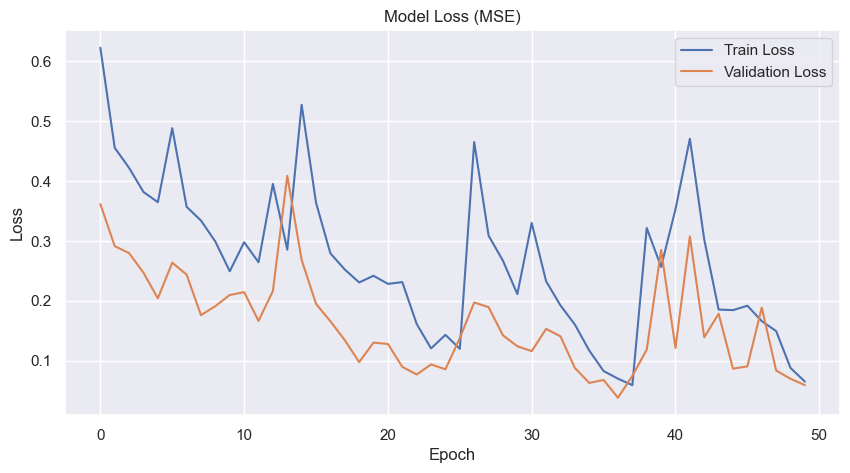

11/11 [==============================] - 0s 6ms/step
     Real Values   Predictions
0         403046  407773.56250
1         397671  404659.25000
2         387589  401155.37500
3         395473  397080.34375
4         406162  393751.46875
..           ...           ...
332       411592  437649.90625
333       378184  432491.56250
334       414996  421842.00000
335       437452  414390.12500
336       417780  411668.06250

[337 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 12.76%


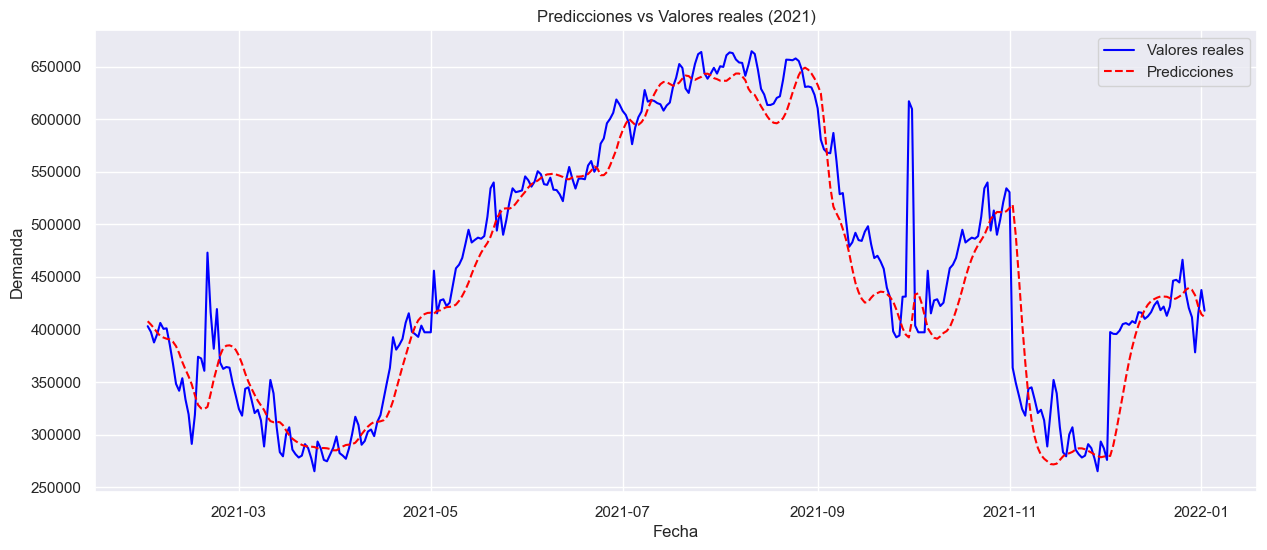

In [202]:
LSTMDemandaDiarioDosCaracteristicas(30, dataRNNdias)

con 60 días

Epoch 1/50
21/21 [==============================] - 3s 54ms/step - loss: 0.1352 - val_loss: 0.0217
Epoch 2/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0175 - val_loss: 0.0155
Epoch 3/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0090 - val_loss: 0.0131
Epoch 4/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0054 - val_loss: 0.0182
Epoch 5/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0042 - val_loss: 1.9783
Epoch 6/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0034 - val_loss: 2.4210
Epoch 7/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0034 - val_loss: 0.3452
Epoch 8/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0034 - val_loss: 0.0127
Epoch 9/50
21/21 [==============================] - 1s 42ms/step - loss: 0.0032 - val_loss: 0.0143
Epoch 10/50
21/21 [==============================] - 1s 42ms/step - loss: 0.0030 - val_loss: 0.0257
Epoch 11/

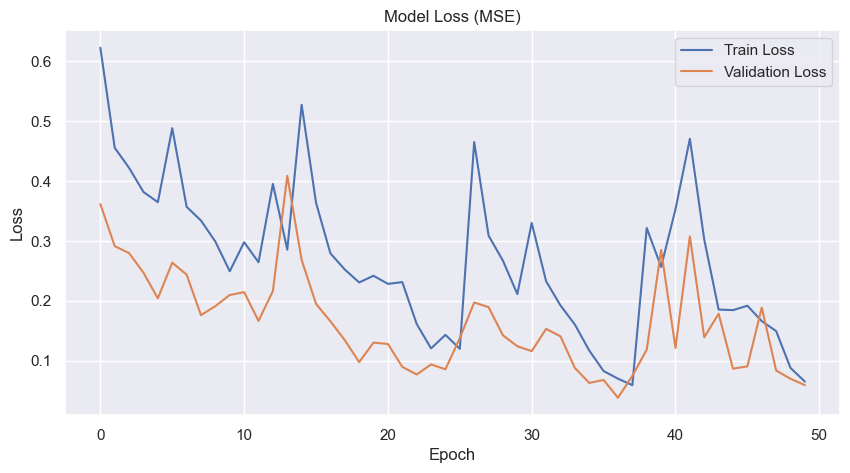

10/10 [==============================] - 0s 12ms/step
     Real Values   Predictions
0         317941  353302.25000
1         343500  344468.65625
2         344890  339445.15625
3         333171  336609.06250
4         320410  333719.00000
..           ...           ...
302       411592  438772.15625
303       378184  433183.15625
304       414996  421415.03125
305       437452  415115.34375
306       417780  415048.84375

[307 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 17.26%


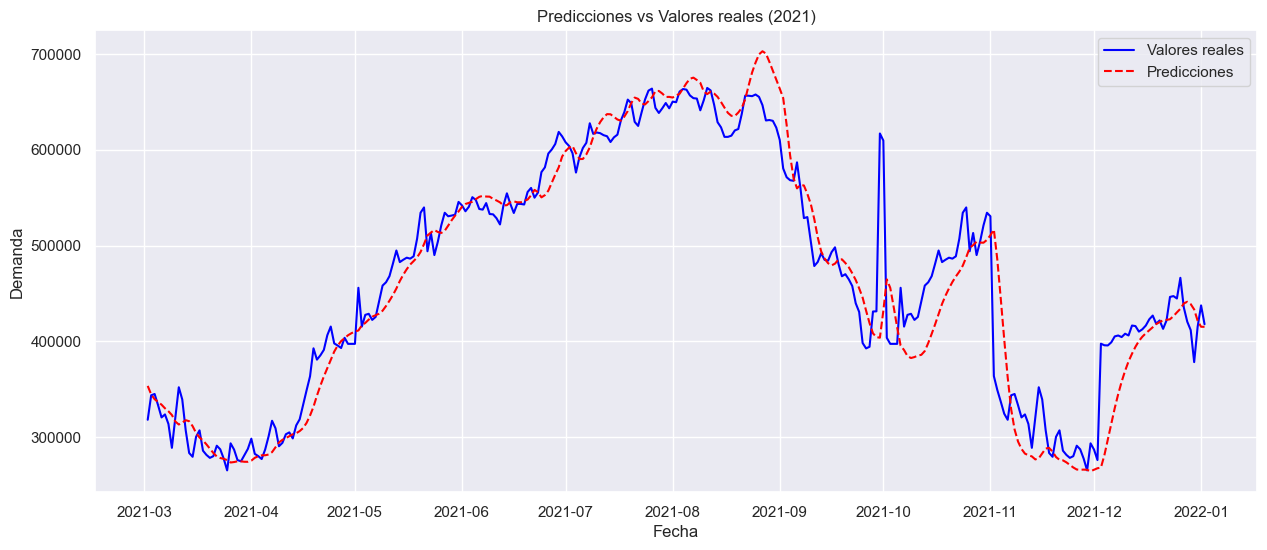

In [203]:
LSTMDemandaDiarioDosCaracteristicas(60, dataRNNdias)

### LSTM para predecir la produccion

In [204]:
def LSTMProduccionDiarioDosCaracteristicas(time_steps, data):
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Produccion']]
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]
    
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # visualización
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo el dia anterior anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 2s 12ms/step - loss: 0.3621 - val_loss: 0.3527
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.2756 - val_loss: 0.2365
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.1519 - val_loss: 0.0734
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0250
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0159 - val_loss: 0.0163
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0128 - val_loss: 0.0158
Epoch 7/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.0143
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0093 - val_loss: 0.0138
Epoch 9/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0131
Epoch 10/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0129
Epoch 11/50
23/23 

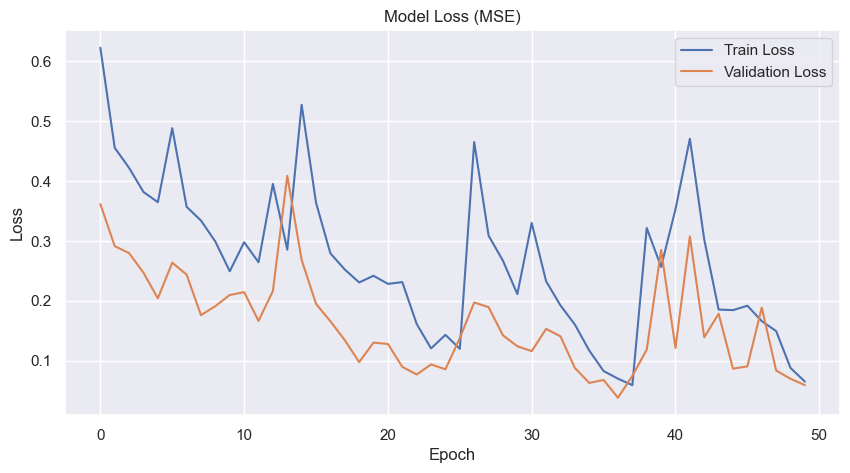

12/12 [==============================] - 0s 1ms/step
     Real Values    Predictions
0         253488  253350.125000
1         258897  256458.968750
2         259925  260989.671875
3         256563  261827.453125
4         256305  259063.375000
..           ...            ...
361       261122  278868.312500
362       248905  262961.375000
363       257533  252269.734375
364       272710  259991.593750
365       277922  273409.718750

[366 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 25.14%


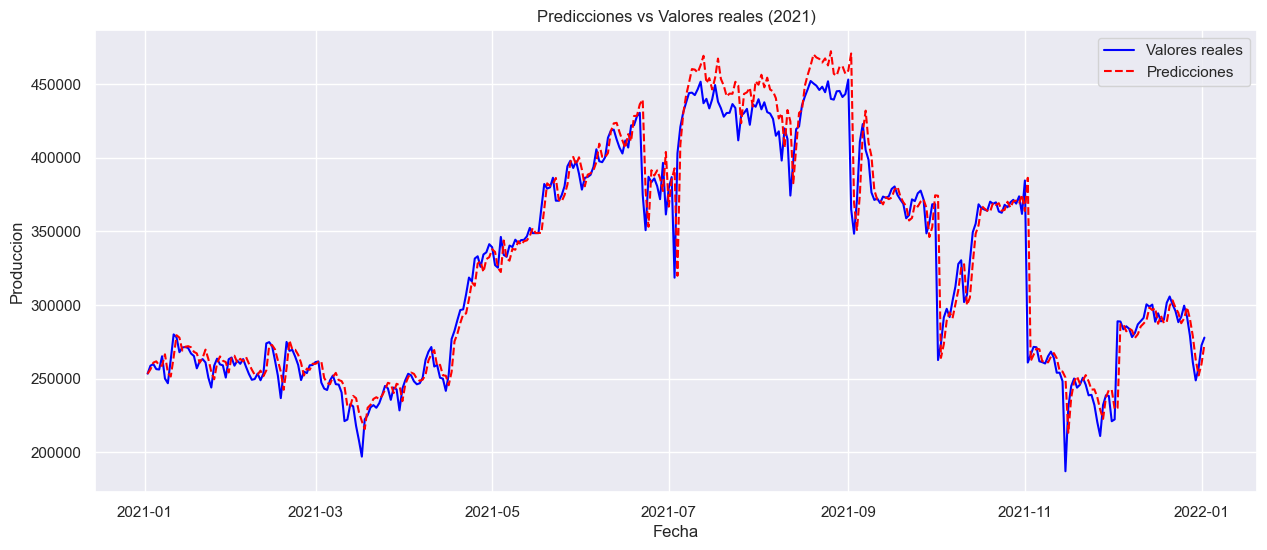

In [205]:
LSTMProduccionDiarioDosCaracteristicas(1, dataRNNdias)

    Cogiendo 7 dias anterior anterior para la prediccion

Epoch 1/50
23/23 [==============================] - 2s 17ms/step - loss: 0.2300 - val_loss: 0.0217
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0175 - val_loss: 0.0151
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0079 - val_loss: 0.0105
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0124
Epoch 5/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0111
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0098
Epoch 7/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0094
Epoch 8/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0090
Epoch 9/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0091
Epoch 10/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0087
Epoch 11/50
23/23 

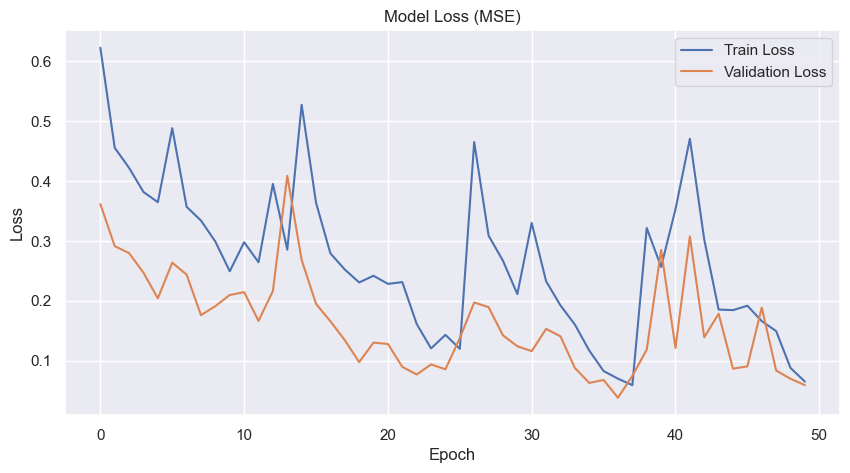

12/12 [==============================] - 0s 2ms/step
     Real Values    Predictions
0         250163  263628.062500
1         246979  262061.187500
2         263122  257753.921875
3         280107  258398.343750
4         278105  266745.000000
..           ...            ...
355       261122  286233.312500
356       248905  273091.843750
357       257533  257854.796875
358       272710  252118.968750
359       277922  260156.250000

[360 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 20.00%


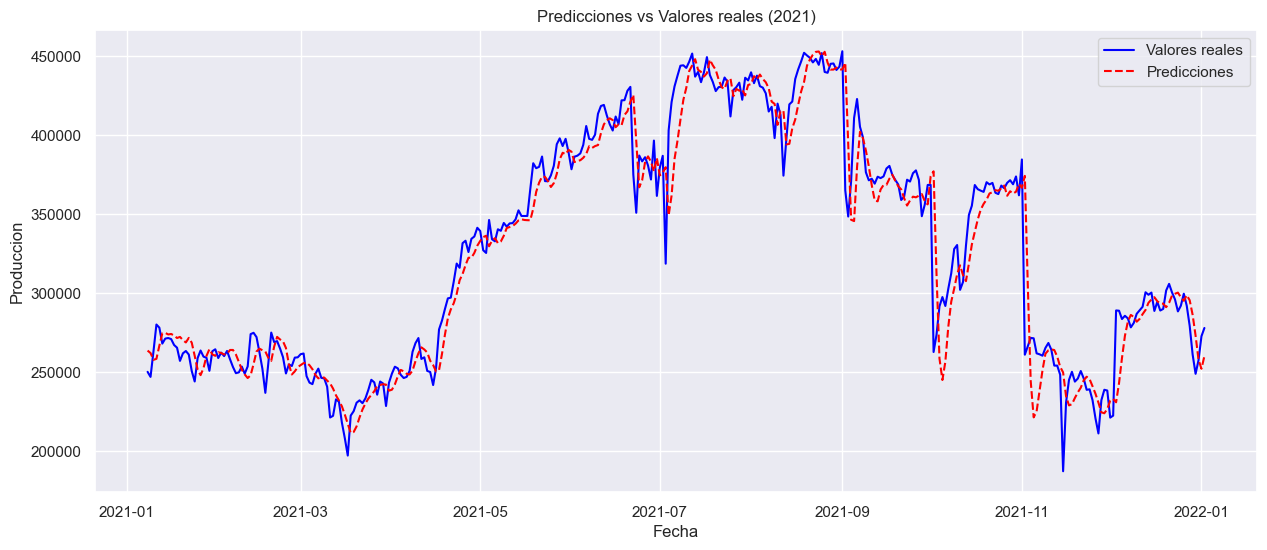

In [206]:
LSTMProduccionDiarioDosCaracteristicas(7, dataRNNdias)

    Cogiendo 30 dias anterior anterior para la prediccion

Epoch 1/50
22/22 [==============================] - 2s 33ms/step - loss: 0.1293 - val_loss: 0.0200
Epoch 2/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0138 - val_loss: 0.0185
Epoch 3/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0099 - val_loss: 0.0175
Epoch 4/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0089 - val_loss: 0.0173
Epoch 5/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0079 - val_loss: 0.0148
Epoch 6/50
22/22 [==============================] - 1s 24ms/step - loss: 0.0072 - val_loss: 0.0146
Epoch 7/50
22/22 [==============================] - 1s 24ms/step - loss: 0.0065 - val_loss: 0.0157
Epoch 8/50
22/22 [==============================] - 1s 24ms/step - loss: 0.0056 - val_loss: 0.0120
Epoch 9/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0044 - val_loss: 0.0122
Epoch 10/50
22/22 [==============================] - 1s 23ms/step - loss: 0.0039 - val_loss: 0.0126
Epoch 11/

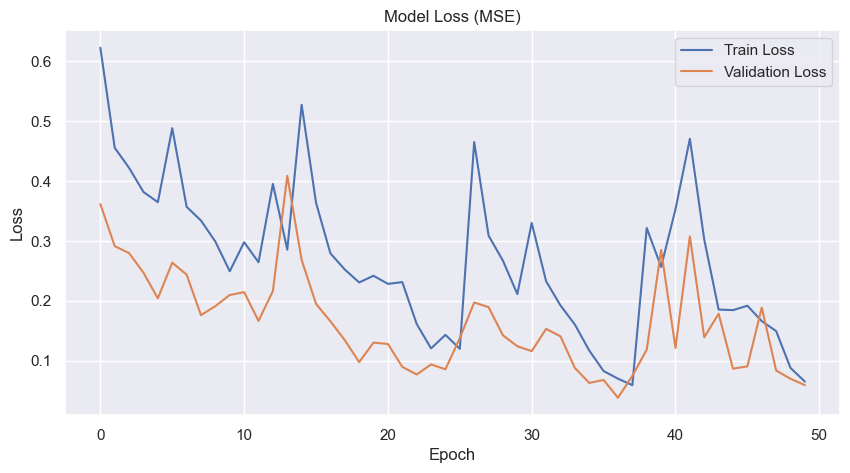

11/11 [==============================] - 0s 6ms/step
     Real Values   Predictions
0         264439  263221.15625
1         258896  263061.34375
2         262317  262702.46875
3         260137  262445.25000
4         263383  262255.96875
..           ...           ...
332       261122  301681.31250
333       248905  297349.34375
334       257533  290700.12500
335       272710  284741.50000
336       277922  281084.59375

[337 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 15.73%


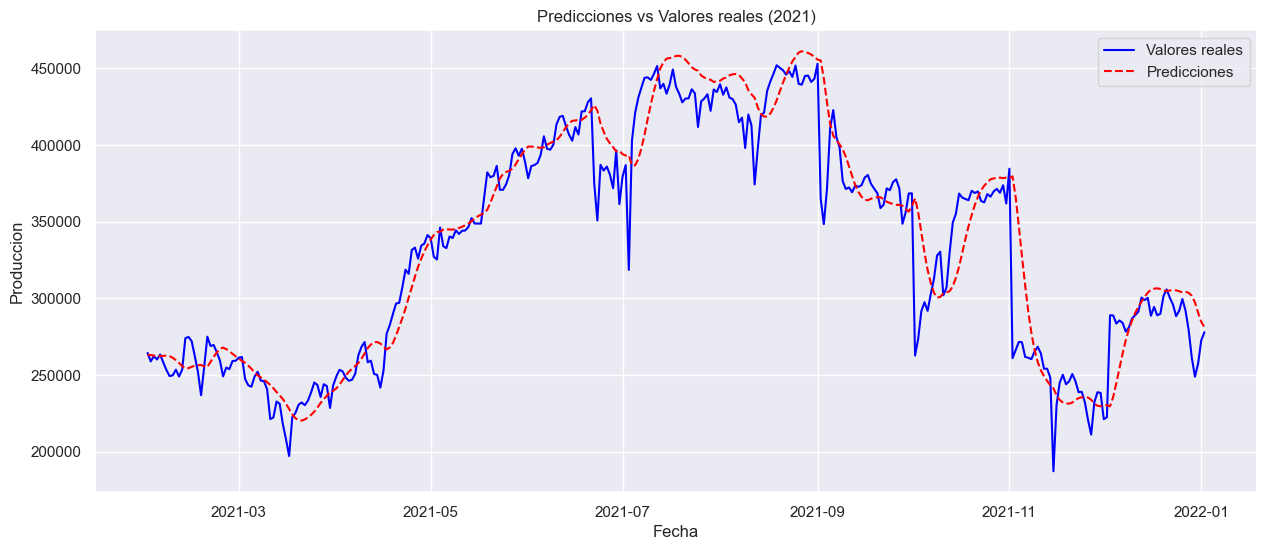

In [207]:
LSTMProduccionDiarioDosCaracteristicas(30, dataRNNdias)

60 dias antes

Epoch 1/50
21/21 [==============================] - 3s 56ms/step - loss: 0.1652 - val_loss: 0.0367
Epoch 2/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0124 - val_loss: 0.0237
Epoch 3/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0092 - val_loss: 0.0211
Epoch 4/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0082 - val_loss: 0.0180
Epoch 5/50
21/21 [==============================] - 1s 44ms/step - loss: 0.0072 - val_loss: 0.0154
Epoch 6/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0060 - val_loss: 0.0133
Epoch 7/50
21/21 [==============================] - 1s 44ms/step - loss: 0.0050 - val_loss: 0.0138
Epoch 8/50
21/21 [==============================] - 1s 42ms/step - loss: 0.0047 - val_loss: 0.0142
Epoch 9/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0044 - val_loss: 0.0135
Epoch 10/50
21/21 [==============================] - 1s 42ms/step - loss: 0.0042 - val_loss: 0.0130
Epoch 11/

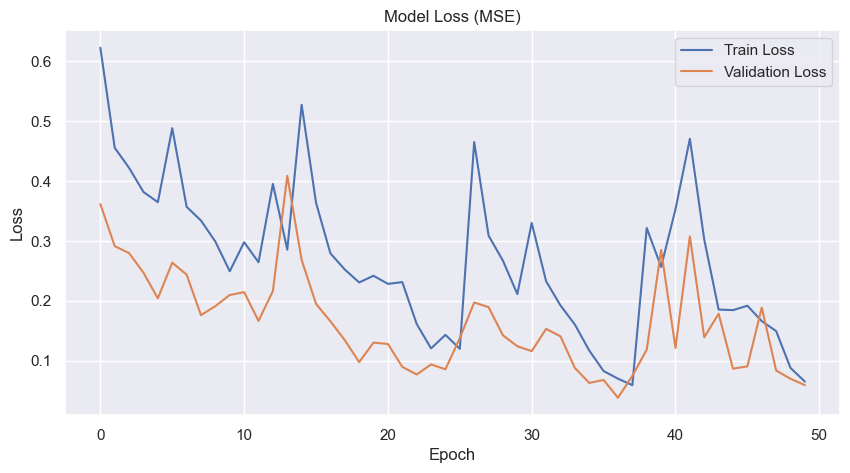

10/10 [==============================] - 0s 11ms/step
     Real Values    Predictions
0         261769  253996.328125
1         247453  252059.484375
2         243335  250260.593750
3         242392  248421.812500
4         248930  246260.531250
..           ...            ...
302       261122  300803.125000
303       248905  296769.593750
304       257533  289741.718750
305       272710  284498.656250
306       277922  281815.843750

[307 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 18.24%


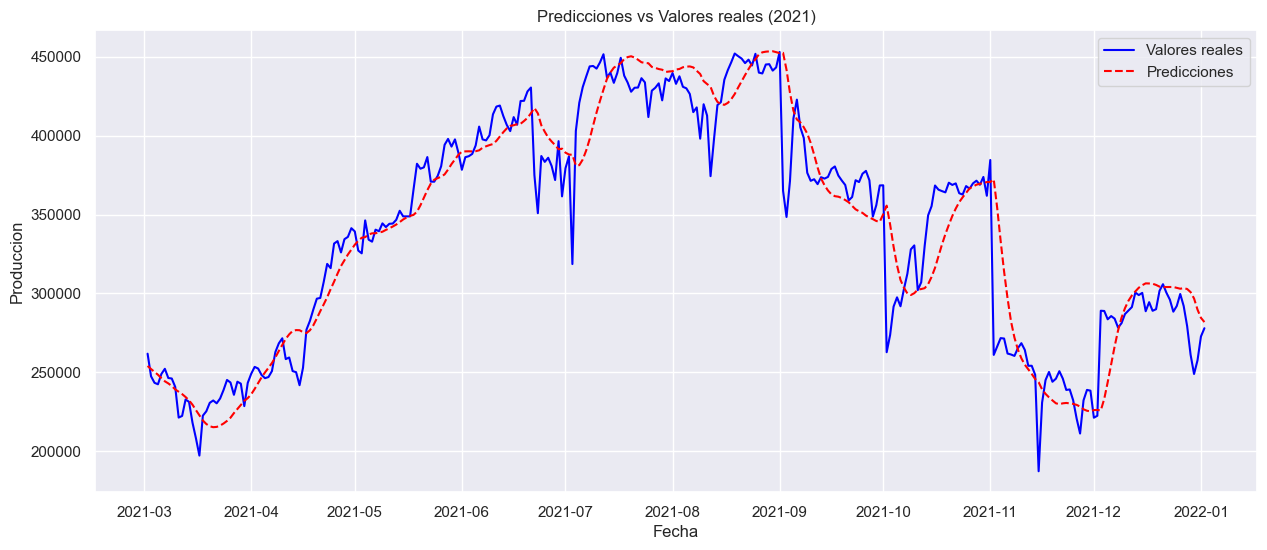

In [208]:
LSTMProduccionDiarioDosCaracteristicas(60, dataRNNdias)

# LSTM por meses con ambas características

Ahora repetimos el proceso pero con algunos cambios y la frecuencia por meses

In [209]:
dataMes= data.resample('m').sum()
dataMes

Demanda  Produccion
fecha                           
2019-01-31  12344034     8892026
2019-02-28  10327355     7753904
2019-03-31   9566047     7603419
2019-04-30   8329040     6860510
2019-05-31  11823599    10597214
2019-06-30  14146614    11740792
2019-07-31  15465729    12511220
2019-08-31  15627938    12676743
2019-09-30  14477503    11977411
2019-10-31  11810422     9998288
2019-11-30   7949894     7243726
2019-12-31  11446699     8653209
2020-01-31  13489781     9110785
2020-02-29  11022374     8862696
2020-03-31   8662324     7728448
2020-04-30   8747987     8081607
2020-05-31  12767656    10977659
2020-06-30  14905798    11627558
2020-07-31  18199501    12252714
2020-08-31  17827320    12969990
2020-09-30  16403785    12160900
2020-10-31  10320331     9483095
2020-11-30   8397757     7106362
2020-12-31  11644426     7536600
2021-01-31  13005501     8091202
2021-02-28  10390139     7253635
2021-03-31   9342708     7317690
2021-04-30  10272893     8450198
2021-05-31  14984538    11166675
2021-06-30  16670675    11921123
2021-07-31  19392643    13231958
2021-08-31  19935514    13392505
2021-09-30  14896197    11319400
2021-10-31  14652679    10581169
2021-11-30   9516929     7544319
2021-12-31  12224975     8528453

### LSTM para predecir la demanda

In [210]:
def LSTMDemandaMensualDosCaracteristicas(time_steps, data):
    
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Demanda']]
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]
    

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

   
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # visualización
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()


    Cogiendo 1 mes anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.2706 - val_loss: 0.4531
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2682 - val_loss: 0.4498
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2659 - val_loss: 0.4467
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2637 - val_loss: 0.4437
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2616 - val_loss: 0.4408
Epoch 6/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2595 - val_loss: 0.4380
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2575 - val_loss: 0.4351
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2555 - val_loss: 0.4323
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2535 - val_loss: 0.4294
Epoch 10/50
1/1 [==============================] - 0s 22ms/step - loss: 0.2515 - val_loss: 0.4266
Epoch 11/50
1/1 [==============

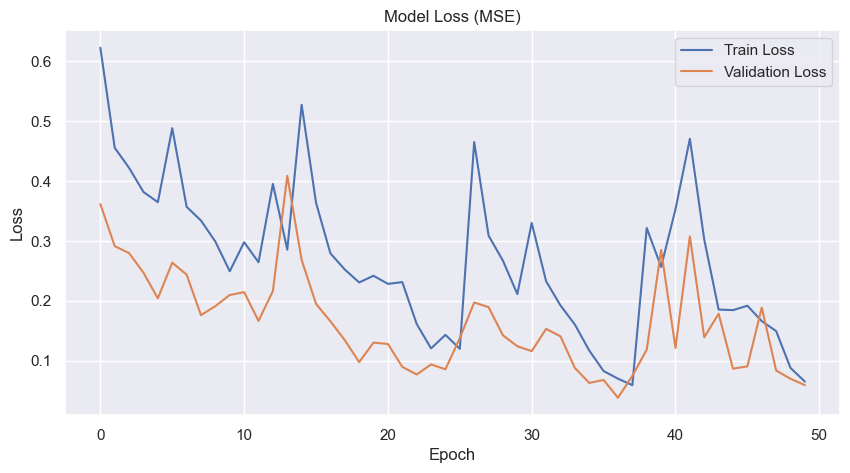

1/1 [==============================] - 0s 169ms/step
    Real Values  Predictions
0      10390139    9640461.0
1       9342708    9439690.0
2      10272893    9389513.0
3      14984538    9521165.0
4      16670675    9999609.0
5      19392643   10163484.0
6      19935514   10446702.0
7      14896197   10495684.0
8      14652679   10007009.0
9       9516929    9932240.0
10     12224975    9414792.0
Accuracy basado en un umbral del 1.0%: 0.00%


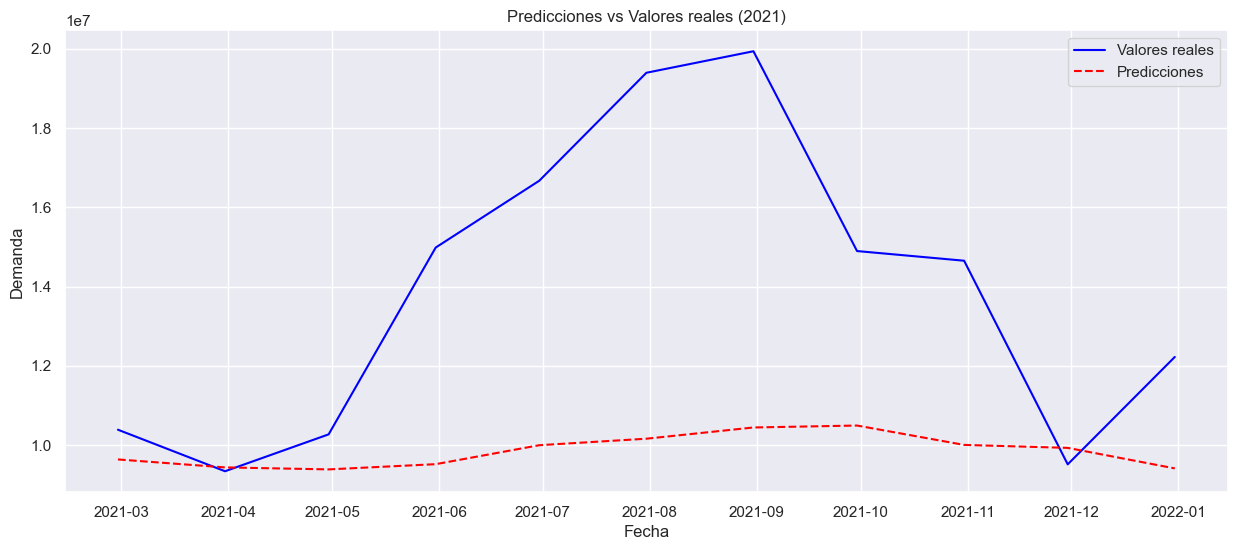

In [211]:
LSTMDemandaMensualDosCaracteristicas(1, dataMes)

    Cogiendo 6 meses anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.2847 - val_loss: 0.5448
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2752 - val_loss: 0.5287
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2661 - val_loss: 0.5124
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2571 - val_loss: 0.4964
Epoch 5/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2484 - val_loss: 0.4811
Epoch 6/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2399 - val_loss: 0.4656
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2314 - val_loss: 0.4498
Epoch 8/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2228 - val_loss: 0.4337
Epoch 9/50
1/1 [==============================] - 0s 27ms/step - loss: 0.2142 - val_loss: 0.4175
Epoch 10/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2055 - val_loss: 0.4010
Epoch 11/50
1/1 [==============

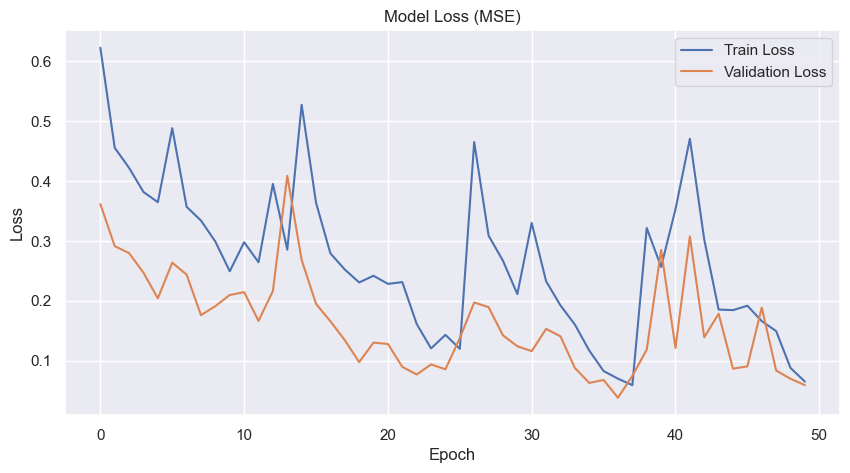

1/1 [==============================] - 0s 180ms/step
   Real Values  Predictions
0     19392643   12817094.0
1     19935514   12959000.0
2     14896197   13212775.0
3     14652679   13381444.0
4      9516929   13493423.0
5     12224975   13373056.0
Accuracy basado en un umbral del 1.0%: 0.00%


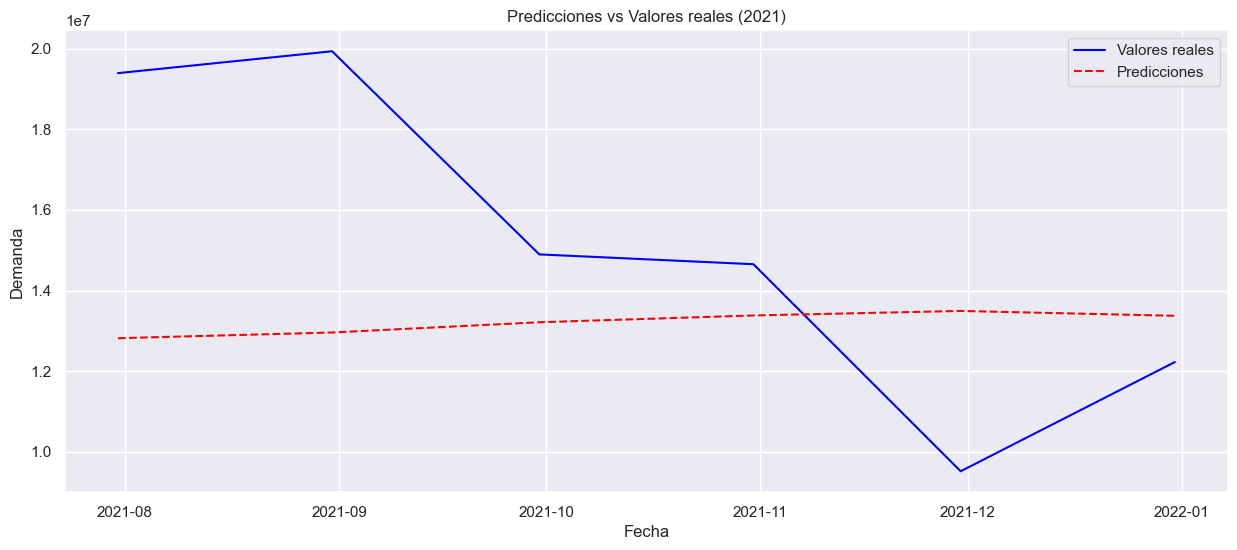

In [212]:
LSTMDemandaMensualDosCaracteristicas(6, dataMes)

### LSTM para predecir la produccion

In [213]:
def LSTMProduccionMensualDosCaracteristicas(time_steps, data):
    
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Produccion']]
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]
    

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

   
    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    # visualización
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()


    Cogiendo el mes anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.3450 - val_loss: 0.4024
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3420 - val_loss: 0.3989
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3390 - val_loss: 0.3955
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3360 - val_loss: 0.3921
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3330 - val_loss: 0.3887
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3300 - val_loss: 0.3853
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3270 - val_loss: 0.3818
Epoch 8/50
1/1 [==============================] - 0s 24ms/step - loss: 0.3240 - val_loss: 0.3783
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.3208 - val_loss: 0.3747
Epoch 10/50
1/1 [==============================] - 0s 22ms/step - loss: 0.3177 - val_loss: 0.3710
Epoch 11/50
1/1 [==============

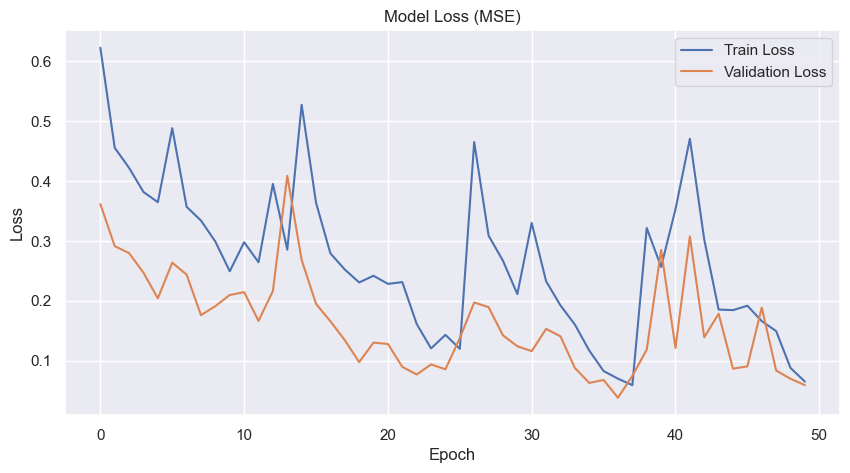

1/1 [==============================] - 0s 173ms/step
    Real Values  Predictions
0       7253635    8338327.5
1       7317690    8107820.0
2       8450198    8066863.5
3      11166675    8247526.5
4      11921123    8868497.0
5      13231958    9084741.0
6      13392505    9475315.0
7      11319400    9540223.0
8      10581169    8885865.0
9       7544319    8764200.0
10      8528453    8101641.5
Accuracy basado en un umbral del 1.0%: 0.00%


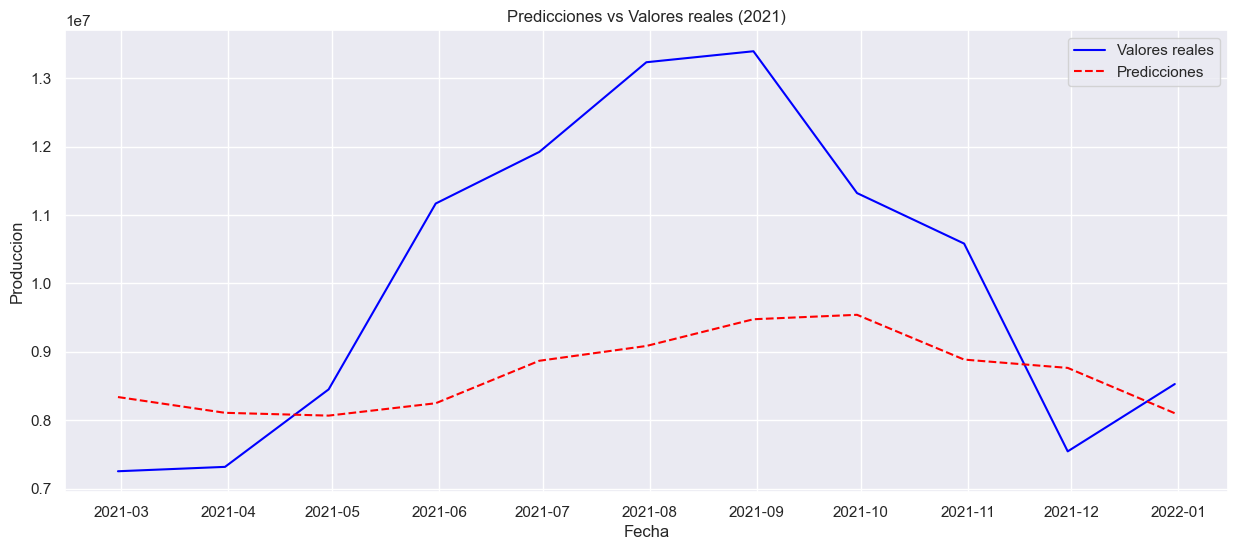

In [214]:
LSTMProduccionMensualDosCaracteristicas(1, dataMes)

    Cogiendo 6 meses anterior anterior para la prediccion

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.3992 - val_loss: 0.5410
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3850 - val_loss: 0.5243
Epoch 3/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3726 - val_loss: 0.5089
Epoch 4/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3624 - val_loss: 0.4950
Epoch 5/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3535 - val_loss: 0.4829
Epoch 6/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3457 - val_loss: 0.4722
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3383 - val_loss: 0.4618
Epoch 8/50
1/1 [==============================] - 0s 26ms/step - loss: 0.3310 - val_loss: 0.4513
Epoch 9/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3235 - val_loss: 0.4405
Epoch 10/50
1/1 [==============================] - 0s 25ms/step - loss: 0.3160 - val_loss: 0.4295
Epoch 11/50
1/1 [==============

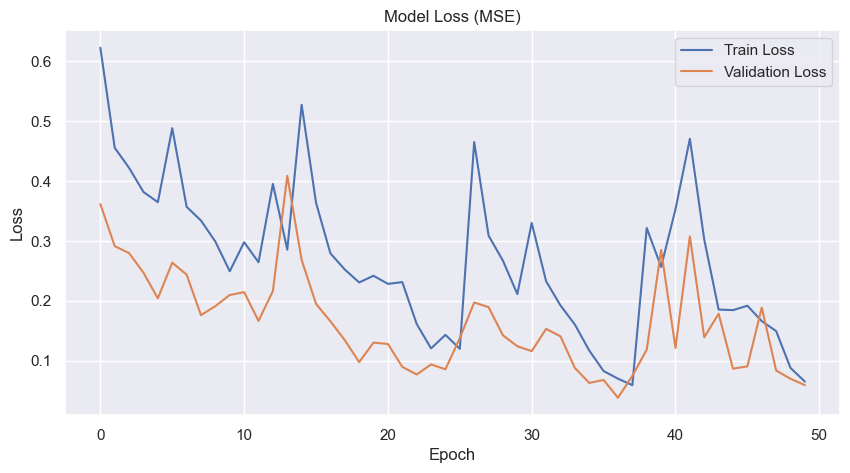

1/1 [==============================] - 0s 171ms/step
   Real Values  Predictions
0     13231958    9326752.0
1     13392505    9510813.0
2     11319400    9851656.0
3     10581169   10168395.0
4      7544319   10404385.0
5      8528453   10299210.0
Accuracy basado en un umbral del 1.0%: 0.00%


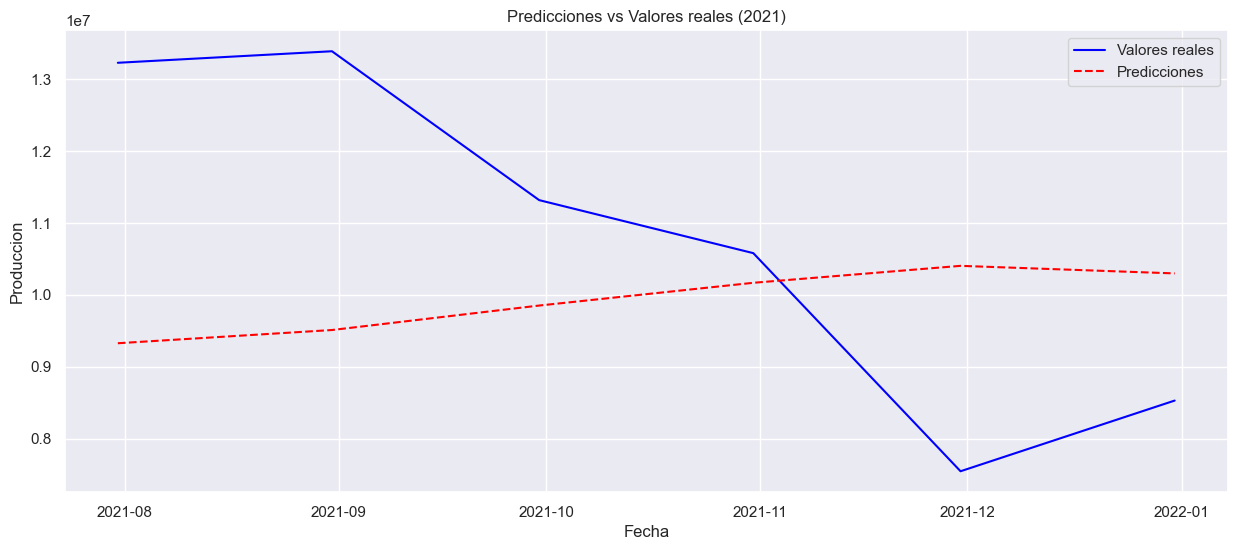

In [215]:
LSTMProduccionMensualDosCaracteristicas(6, dataMes)

# LSTM por horas con ambas características

In [216]:
dataHoraDemandaLSTM = pd.read_csv("datosHorarios.csv")

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraDemandaLSTM), freq='H')
dataHoraDemandaLSTM.index = date_hour_index

In [217]:
dataHoraDemandaLSTM

Produccion  Hours  Demanda
2019-01-01 00:00:00       10494      1    11479
2019-01-01 01:00:00        9914      2    10595
2019-01-01 02:00:00        9452      3    10132
2019-01-01 03:00:00        9334      4    10437
2019-01-01 04:00:00        9832      5    11576
...                         ...    ...      ...
2022-01-02 19:00:00       12754     20    19725
2022-01-02 20:00:00       12639     21    18376
2022-01-02 21:00:00       12320     22    17323
2022-01-02 22:00:00       11802     23    16220
2022-01-02 23:00:00       11000     24    15341

[26352 rows x 3 columns]

### LSTM para predecir la demanda

In [218]:
def LSTMDemandaHorarioDosCaracteristicas(time_steps, data):
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Demanda']]
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha y Hora")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()



    Cogiendo la hora anterior para la prediccion

Epoch 1/50
548/548 [==============================] - 3s 3ms/step - loss: 0.0246 - val_loss: 0.0022
Epoch 2/50
548/548 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/50
548/548 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 4/50
548/548 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/50
548/548 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 6/50
548/548 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/50
548/548 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 8/50
548/548 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/50
548/548 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/50
548/548 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0014

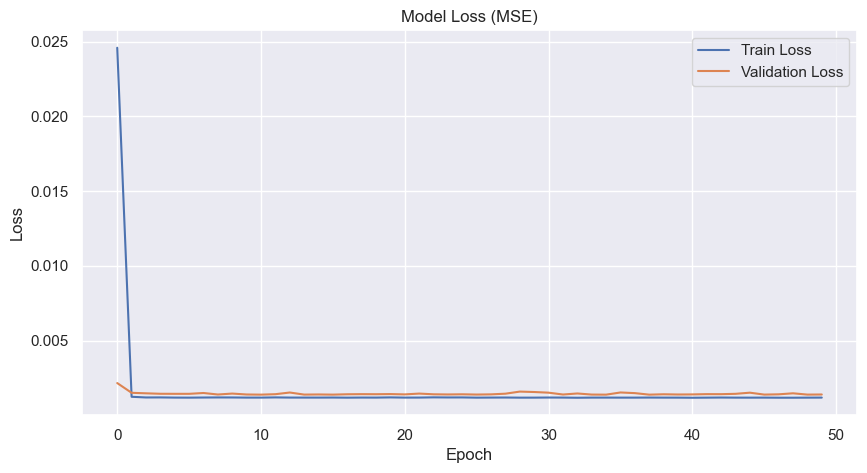

276/276 [==============================] - 0s 788us/step
      Real Values   Predictions
0           11928  12522.034180
1           11879  11928.986328
2           12429  11879.962891
3           13359  12393.526367
4           14670  13276.075195
...           ...           ...
8801        19725  20816.287109
8802        18376  19627.437500
8803        17323  18268.066406
8804        16220  17192.449219
8805        15341  16082.508789

[8806 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 13.00%


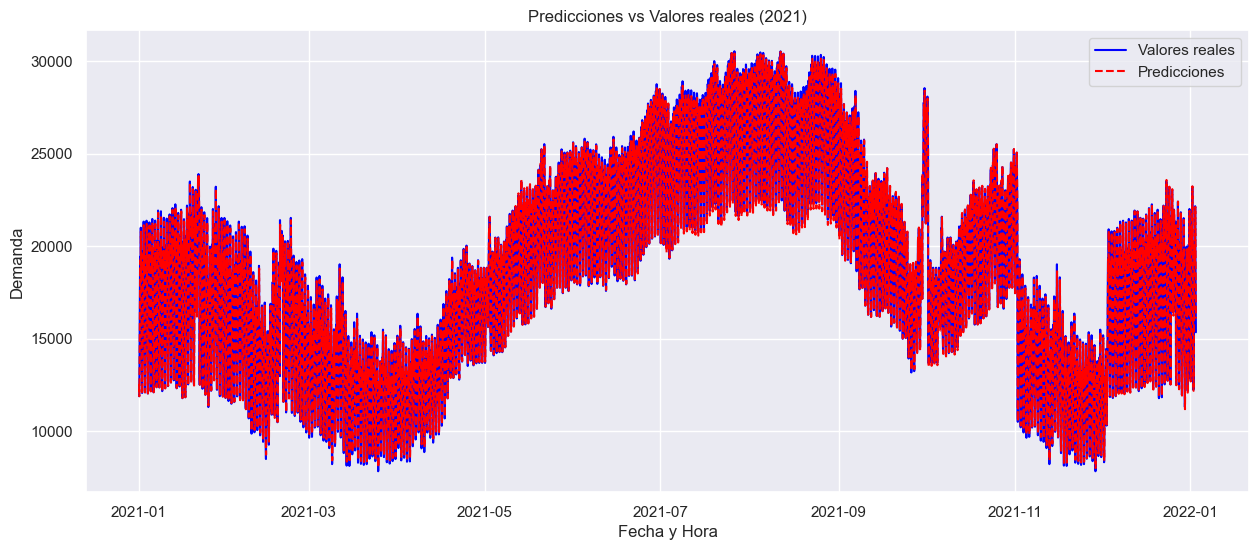

In [219]:
LSTMDemandaHorarioDosCaracteristicas(1, dataHoraDemandaLSTM)

    Cogiendo 24 horas anterior para la prediccion

Epoch 1/50
547/547 [==============================] - 11s 17ms/step - loss: 0.0099 - val_loss: 0.0016
Epoch 2/50
547/547 [==============================] - 9s 17ms/step - loss: 7.8363e-04 - val_loss: 0.0016
Epoch 3/50
547/547 [==============================] - 9s 17ms/step - loss: 6.6590e-04 - val_loss: 0.0014
Epoch 4/50
547/547 [==============================] - 9s 17ms/step - loss: 5.4987e-04 - val_loss: 0.0012
Epoch 5/50
547/547 [==============================] - 9s 17ms/step - loss: 4.8440e-04 - val_loss: 0.0015
Epoch 6/50
547/547 [==============================] - 9s 17ms/step - loss: 4.7974e-04 - val_loss: 9.7704e-04
Epoch 7/50
547/547 [==============================] - 9s 17ms/step - loss: 4.2647e-04 - val_loss: 8.6161e-04
Epoch 8/50
547/547 [==============================] - 9s 17ms/step - loss: 3.9838e-04 - val_loss: 7.8196e-04
Epoch 9/50
547/547 [==============================] - 9s 17ms/step - loss: 3.8058e-04 - val_loss: 8.1212e-04
Epoch 10/50
547/547 [=====================

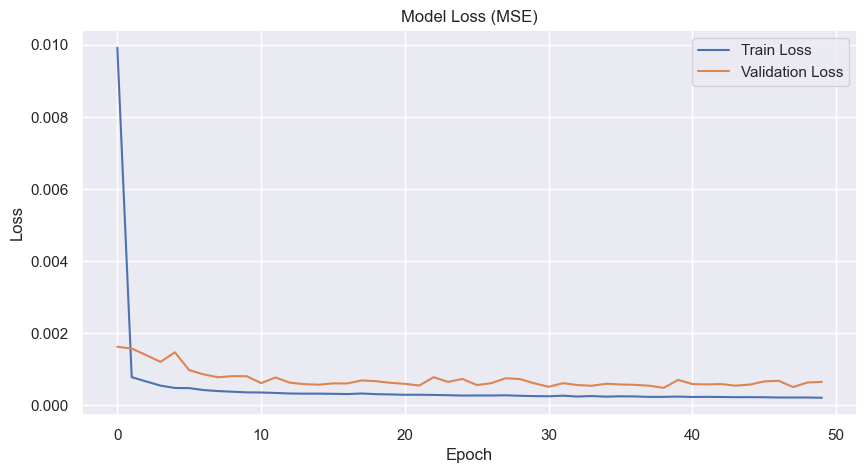

275/275 [==============================] - 2s 5ms/step
      Real Values   Predictions
0           12756  12784.902344
1           12115  12047.624023
2           12053  11801.601562
3           12583  12345.024414
4           13543  13428.234375
...           ...           ...
8778        19725  20130.453125
8779        18376  18845.869141
8780        17323  17490.857422
8781        16220  16456.931641
8782        15341  15004.381836

[8783 rows x 2 columns]
Accuracy basado en un umbral del 1.0%: 36.64%


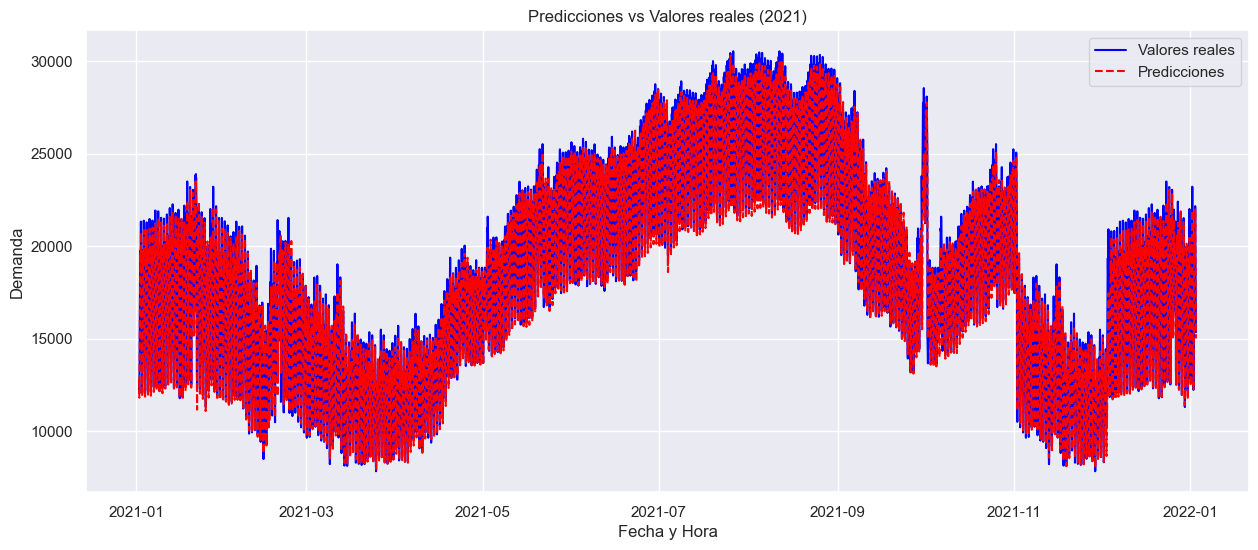

In [220]:
LSTMDemandaHorarioDosCaracteristicas(24, dataHoraDemandaLSTM)

    Cogiendo una semana anterior para la prediccion

In [221]:
LSTMDemandaHorarioDosCaracteristicas(168, dataHoraDemandaLSTM)

Epoch 1/50
543/543 [==============================] - 70s 125ms/step - loss: 0.0091 - val_loss: 0.0017
Epoch 2/50
543/543 [==============================] - 65s 120ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3/50
543/543 [==============================] - 65s 121ms/step - loss: 8.7507e-04 - val_loss: 0.0011
Epoch 4/50
543/543 [==============================] - 66s 121ms/step - loss: 7.7071e-04 - val_loss: 0.0011
Epoch 5/50
543/543 [==============================] - 65s 120ms/step - loss: 6.9910e-04 - val_loss: 7.6766e-04
Epoch 6/50
543/543 [==============================] - 65s 120ms/step - loss: 6.1543e-04 - val_loss: 8.2704e-04
Epoch 7/50
543/543 [==============================] - 65s 120ms/step - loss: 5.5870e-04 - val_loss: 6.6015e-04
Epoch 8/50
543/543 [==============================] - 65s 120ms/step - loss: 4.9221e-04 - val_loss: 7.1688e-04
Epoch 9/50
543/543 [==============================] - 65s 120ms/step - loss: 5.0799e-04 - val_loss: 6.4696e-04
Epoch 10/50
543/543 [====

KeyboardInterrupt: 

### LSTM por horas para predecir la produccion

In [ ]:
dataHoraProduccionLSTM = pd.read_csv("datosHorarios.csv")

date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraProduccionLSTM), freq='H')
dataHoraProduccionLSTM.index = date_hour_index

In [ ]:
dataHoraProduccionLSTM

In [ ]:


def LSTMProduccionHorarioDosCaracteristicas(time_steps, data):
    inputs = data[['Demanda', 'Produccion']]
    target = data[['Produccion']]
    
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 00:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    
    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01  # Se han echo varias pruebas y se coge finalmente el 1% del valor real

    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Fecha y Hora")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo la hora anterior para la prediccion

In [ ]:
LSTMProduccionHorarioDosCaracteristicas(1, dataHoraProduccionLSTM)

    Cogiendo el dia anterior para la prediccion

In [ ]:
LSTMProduccionHorarioDosCaracteristicas(24, dataHoraProduccionLSTM)

    Cogiendo una semana anterior para la prediccion

In [ ]:
#LSTMProduccionHorarioDosCaracteristicas(168, dataHoraProduccionLSTM)

# LSTM por días para predecir la demanda solo con la demanda

In [ ]:
dataRNNdiasDemanda = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasDemanda), freq='D')
dataRNNdiasDemanda.index = date_index

In [ ]:
demand = dataRNNdiasDemanda[['Demanda']]
train_data = demand.loc['2019-01-01':'2020-12-31']
val_data = demand.loc['2021-01-01':'2021-12-31']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
look_back=1
def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)


X_train, y_train = prepare_data(train_scaled, look_back=look_back)
X_val, y_val = prepare_data(val_scaled, look_back=look_back)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
comparison = pd.DataFrame({'Real Values': val_data['Demanda'].iloc[look_back:].values, 'Predictions': predictions})

print(comparison)



In [ ]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]
threshold = 0.01  # Se han hecho varias pruebas y se coge finalmente el 1% del valor real

correct_predictions = np.abs(predictions - val_data['Demanda'].iloc[look_back:].values) <= threshold * val_data['Demanda'].iloc[look_back:].values
accuracy = np.mean(correct_predictions)

print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


In [ ]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(np.hstack((np.zeros(predictions.shape), predictions)))[:,1]

plt.figure(figsize=(15, 6))

plt.plot(val_data.index[look_back:], val_data['Demanda'].iloc[look_back:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[look_back:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()


## LSTM por días para predecir la produccion solo con la produccion

In [ ]:
dataRNNdiasProduccion = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasProduccion), freq='D')
dataRNNdiasProduccion.index = date_index

In [ ]:
produccion = dataRNNdiasDemanda[['Produccion']]
train_data = produccion.loc['2019-01-01':'2020-12-31']
val_data = produccion.loc['2021-01-01':'2021-12-31']

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

look_back = 7

def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled, look_back)
X_val, y_val = prepare_data(val_scaled, look_back)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)
comparison = pd.DataFrame({'Real Values': val_data['Produccion'].iloc[look_back:].values.flatten(), 'Predictions': predictions.flatten()})

print(comparison)


In [ ]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions).flatten()

threshold = 0.01  # Se han hecho varias pruebas y se coge finalmente el 1% del valor real
correct_predictions = np.abs(predictions - val_data['Produccion'].iloc[look_back:].values) <= threshold * val_data['Produccion'].iloc[look_back:].values
accuracy = np.mean(correct_predictions)

print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


In [ ]:
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions).flatten()

plt.figure(figsize=(15, 6))

plt.plot(val_data.index[look_back:], val_data['Produccion'].iloc[look_back:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[look_back:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha")
plt.ylabel("Produccion")
plt.legend()
plt.grid(True)
plt.show()


## LSTM por horas para predecir la demanda solo con la demanda

In [ ]:
dataHoraDemanda = pd.read_csv("datosHorarios.csv")


In [ ]:
date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraDemanda), freq='H')
dataHoraDemanda.index = date_hour_index
demand = dataHoraDemanda[['Demanda']]
train_data = demand.loc['2019-01-01':'2020-12-31 23:00:00']
val_data = demand.loc['2021-01-01':'2021-12-31 23:00:00']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

look_back = 24
def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled, look_back)
X_val, y_val = prepare_data(val_scaled, look_back)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)
plt.figure(figsize=(15, 6))
plt.plot(val_data.index[look_back:], val_data['Demanda'].iloc[look_back:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[look_back:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
comparison = pd.DataFrame({'Real Values': val_data['Demanda'].iloc[look_back:].values, 'Predictions': predictions.flatten()})
print(comparison)

threshold = 0.01  # Se han hecho varias pruebas y se coge finalmente el 1% del valor real
correct_predictions = np.abs(predictions.flatten() - val_data['Demanda'].iloc[look_back:].values) <= threshold * val_data['Demanda'].iloc[look_back:].values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

## LSTM por horas para predecir la produccion solo con la produccion


In [ ]:
dataHoraProduccion = pd.read_csv("datosHorarios.csv")

In [ ]:
date_hour_index = pd.date_range(start="01-01-2019", periods=len(dataHoraProduccion), freq='H')
dataHoraProduccion.index = date_hour_index

produccion = dataHoraProduccion[['Produccion']]

train_data = produccion.loc['2019-01-01':'2020-12-31 23:00:00']
val_data = produccion.loc['2021-01-01':'2021-12-31 23:00:00']

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

look_back = 24
def prepare_data(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data(train_scaled, look_back)
X_val, y_val = prepare_data(val_scaled, look_back)

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)

predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(15, 6))
plt.plot(val_data.index[look_back:], val_data['Produccion'].iloc[look_back:].values, label="Valores reales", color='blue')
plt.plot(val_data.index[look_back:], predictions, label="Predicciones", color='red', linestyle='dashed')
plt.title("Predicciones vs Valores reales (2021)")
plt.xlabel("Fecha y Hora")
plt.ylabel("Produccion")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
comparison = pd.DataFrame({'Real Values': val_data['Produccion'].iloc[look_back:].values, 'Predictions': predictions.flatten()})
print(comparison)

threshold = 0.01  # Se han hecho varias pruebas y se coge finalmente el 1% del valor real

correct_predictions = np.abs(predictions.flatten() - val_data['Produccion'].iloc[look_back:].values) <= threshold * val_data['Produccion'].iloc[look_back:].values
accuracy = np.mean(correct_predictions)
print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")


## LSTM para predecir la demanda con todas las caracteristicas diaria

In [ ]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index

In [ ]:
def LSTMDemandaDiaria2(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()



    Cogiendo un día anterior para la prediccion

In [ ]:
LSTMDemandaDiaria2(1, dataFullCaracteristicas)

    Cogiendo 7 dias anterior para la prediccion

In [ ]:
LSTMDemandaDiaria2(7, dataFullCaracteristicas)

    Cogiendo 30 días anterior para la prediccion

In [ ]:
LSTMDemandaDiaria2(30, dataFullCaracteristicas)

    Cogiendo 60 dias anterior para la prediccion

In [ ]:
LSTMDemandaDiaria2(60, dataFullCaracteristicas)

## LSTM para predecir la producción con todas las caracteristicas diaria

In [ ]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index

In [ ]:
def LSTMProduccionDiaria(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Produccion']]
    
    train_inputs = inputs.loc['2019-01-01':'2020-12-31']
    train_target = target.loc['2019-01-01':'2020-12-31']
    val_inputs = inputs.loc['2021-01-01':]
    val_target = target.loc['2021-01-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()

      Cogiendo un día anterior para la prediccion

In [ ]:
LSTMProduccionDiaria(1, dataFullCaracteristicas)

      Cogiendo 7 dias anterior para la prediccion

In [ ]:
LSTMProduccionDiaria(7, dataFullCaracteristicas)

      Cogiendo 30 dias anterior para la prediccion

In [ ]:
LSTMProduccionDiaria(30, dataFullCaracteristicas)

      Cogiendo 60 dias anterior para la prediccion

In [ ]:
LSTMProduccionDiaria(30, dataFullCaracteristicas)

## LSTM para predecir la demanda con todas las caracteristicas por horas

In [ ]:
dataHoras= pd.read_csv("datosHorarios.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataHoras), freq='D')
dataHoras.index = date_index

In [ ]:
dataHoras

In [ ]:


def LSTMDemandaHoraria(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])
    
    estaciones = ['Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera', 'Estacion_Verano']
    for estacion in estaciones:
        if estacion not in data.columns:
            data[estacion] = 0

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='H'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='H'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='H')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='H'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='H'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='H')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = pd.to_datetime(["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                               "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                               "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"])
    festivos_hours = [pd.date_range(start=f, end=f + pd.Timedelta(days=1), freq='H') for f in festivos]
    
    data['Festivo'] = data.index.isin(np.concatenate(festivos_hours)).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    

    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Horas")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo la hora anterior para la prediccion

In [ ]:
LSTMDemandaHoraria(1,dataHoras)

    Cogiendo 7 horas anterior para la prediccion

In [ ]:
LSTMDemandaHoraria(7,dataHoras)

    Cogiendo 24 horas anterior para la prediccion

In [ ]:
LSTMDemandaHoraria(24,dataHoras)

## LSTM para predecir la producción con todas las caracteristicas por horas

In [ ]:

dataHoras= pd.read_csv("datosHorarios.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataHoras), freq='D')
dataHoras.index = date_index

In [ ]:

def LSTMProduccionHoraria(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])
    
    estaciones = ['Estacion_Invierno', 'Estacion_Otoño', 'Estacion_Primavera', 'Estacion_Verano']
    for estacion in estaciones:
        if estacion not in data.columns:
            data[estacion] = 0

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='H'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='H'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='H')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='H'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='H'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='H')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = pd.to_datetime(["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                               "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                               "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"])
    festivos_hours = [pd.date_range(start=f, end=f + pd.Timedelta(days=1), freq='H') for f in festivos]
    
    data['Festivo'] = data.index.isin(np.concatenate(festivos_hours)).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Produccion']]
    
    train_inputs = inputs.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    train_target = target.loc['2019-01-01 01:00:00':'2020-12-31 23:00:00']
    val_inputs = inputs.loc['2021-01-01 01:00:00':]
    val_target = target.loc['2021-01-01 01:00:00':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history= model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    

    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Horas")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()


        Cogiendo la hora anterior para la prediccion

In [ ]:
LSTMProduccionHoraria(1,dataHoras)

    Cogiendo 7 horas anterior para la prediccion

In [ ]:
LSTMProduccionHoraria(7,dataHoras)

    Cogiendo 24 horas anterior para la prediccion

In [ ]:
LSTMProduccionHoraria(24,dataHoras)

## LSTM para predecir la demanda con todas las caracteristicas por meses

In [ ]:
dataMes= data.resample('m').sum()
dataMes

In [ ]:
def LSTMDemandaMensual(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_months = ["2019-05", "2019-06", "2020-04", "2020-05", "2021-04", "2021-05"]
    shaaban_months = ["2019-04", "2019-05", "2020-03", "2020-04", "2021-03", "2021-04"]

    data['Ramadan'] = data.index.strftime('%Y-%m').isin(ramadan_months).astype(int)
    data['Shaaban'] = data.index.strftime('%Y-%m').isin(shaaban_months).astype(int)

    festivos = ["2019-01", "2019-05", "2019-07", "2019-10", "2020-01", "2020-05", "2020-07", "2020-10", "2021-01", "2021-05", "2021-07", "2021-10"]
    data['Festivo'] = data.index.strftime('%Y-%m').isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

 
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
   
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Meses")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

    Cogiendo el mes anterior para la prediccion

In [ ]:
LSTMDemandaMensual(1,dataMes)

    Cogiendo 6 meses anterior para la prediccion

In [ ]:
LSTMDemandaMensual(6,dataMes)

## LSTM para predecir la producción con todas las caracteristicas por meses

In [ ]:
dataMes= data.resample('m').sum()
dataMes


In [ ]:
def LSTMProduccionMensual(time_steps, data):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    data['Estacion'] = data.index.month.map(assign_season)

    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_months = ["2019-05", "2019-06", "2020-04", "2020-05", "2021-04", "2021-05"]
    shaaban_months = ["2019-04", "2019-05", "2020-03", "2020-04", "2021-03", "2021-04"]

    data['Ramadan'] = data.index.strftime('%Y-%m').isin(ramadan_months).astype(int)
    data['Shaaban'] = data.index.strftime('%Y-%m').isin(shaaban_months).astype(int)

    festivos = ["2019-01", "2019-05", "2019-07", "2019-10", "2020-01", "2020-05", "2020-07", "2020-10", "2021-01", "2021-05", "2021-07", "2021-10"]
    data['Festivo'] = data.index.strftime('%Y-%m').isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Produccion']]
    
    train_inputs = inputs.loc['2019-01':'2020-12']
    train_target = target.loc['2019-01':'2020-12']
    val_inputs = inputs.loc['2021-01':]
    val_target = target.loc['2021-01':]

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

 
    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
   
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)
    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")
    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Meses")
    plt.ylabel("Produccion")
    plt.legend()
    plt.grid(True)
    plt.show()


        Cogiendo el mes anterior para la prediccion

In [ ]:
LSTMProduccionMensual(1,dataMes)


        Cogiendo 6 meses anterior para la prediccion

In [ ]:
LSTMProduccionMensual(6,dataMes)

## LSTM para predecir la demanda de un mes en concreto en con todas las caracteristicas por días

In [ ]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index


In [ ]:
def LSTMDemandaDiariaPorMeses(time_steps, data, month_to_predict):
    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)
    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year != 2021)]
    train_target = target[(target.index.month == month_to_predict) & (target.index.year != 2021)]
    val_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year == 2021)]
    val_target = target[(target.index.month == month_to_predict) & (target.index.year == 2021)]


    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    history=model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()
 

Enero

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 1)

Febrero

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 2)

Marzo

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 3)

Abril

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 4)

Mayo

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas,5)

Junio

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 6)

Julio

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 7)

Agosto

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 8)

Septiembre

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 9)

Octubre

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 10)

Noviembre

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 11)

Diciembre

In [ ]:
LSTMDemandaDiariaPorMeses(1, dataFullCaracteristicas, 12)

# LSTM para predecir la demanda de un mes en concreto con solo la demanda por días

In [ ]:
def LSTMDemandaDiariaPorMesesSoloDemanda(time_steps, data, month_to_predict):
    target = data[['Demanda']]
    
    train_inputs = target[(target.index.month == month_to_predict) & (target.index.year != 2021)]
    val_inputs = target[(target.index.month == month_to_predict) & (target.index.year == 2021)]
    val_target = val_inputs.copy() 

    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_inputs)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), verbose=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()

Enero

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 1)

Febrero

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 2)

Marzo

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 3)

Abril

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 4)

Mayo

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 5)

Junio

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 6)

Julio

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 7)

Agosto

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 8)

Septiembre

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 9)

Octubre

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 10)

Noviembre

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 11)

Diciembre

In [ ]:
LSTMDemandaDiariaPorMesesSoloDemanda(1, dataFullCaracteristicas, 12)

# LSTM para predecir la demanda de un mes en concreto con todas las caracteristicas por días según configuración

In [ ]:
dataFullCaracteristicas = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataFullCaracteristicas), freq='D')
dataFullCaracteristicas.index = date_index


In [ ]:
dataFullCaracteristicas

In [ ]:
def LSTMDemandaDiariaPorMesesConfig(time_steps, data, month_to_predict, config):

    def assign_season(month):
        season_mapping = {
            1: 'Invierno', 2: 'Invierno', 3: 'Invierno',
            4: 'Primavera', 5: 'Primavera',
            6: 'Verano', 7: 'Verano', 8: 'Verano', 9: 'Verano',
            10: 'Otoño', 11: 'Otoño',
            12: 'Invierno'
        }
        return season_mapping[month]
    
    data['Estacion'] = data.index.month.map(assign_season)
    data = pd.get_dummies(data, columns=['Estacion'])

    ramadan_dates = [
        pd.date_range(start="06-may-2019", end="04-jun-2019", freq='D'),
        pd.date_range(start="24-apr-2020", end="23-may-2020", freq='D'),
        pd.date_range(start="13-apr-2021", end="12-may-2021", freq='D')
    ]
    shaaban_dates = [
        pd.date_range(start="06-apr-2019", end="05-may-2019", freq='D'),
        pd.date_range(start="25-mar-2020", end="23-apr-2020", freq='D'),
        pd.date_range(start="14-mar-2021", end="12-apr-2021", freq='D')
    ]

    data['Ramadan'] = data.index.isin(np.concatenate(ramadan_dates)).astype(int)
    data['Shaaban'] = data.index.isin(np.concatenate(shaaban_dates)).astype(int)

    festivos = ["2019-01-01", "2019-01-06", "2019-05-01", "2019-07-14", "2019-10-03",
                "2020-01-01", "2020-01-06", "2020-05-01", "2020-07-14", "2020-10-03",
                "2021-01-01", "2021-01-06", "2021-05-01", "2021-07-14", "2021-10-03"]
    data['Festivo'] = data.index.isin(festivos).astype(int)

    input_columns = ['Demanda', 'Produccion', 'Estacion_Invierno', 'Estacion_Otoño', 
                     'Estacion_Primavera', 'Estacion_Verano', 'Ramadan', 'Shaaban', 'Festivo']
    inputs = data[input_columns]
    target = data[['Demanda']]
    
    train_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year != 2021)]
    train_target = target[(target.index.month == month_to_predict) & (target.index.year != 2021)]
    val_inputs = inputs[(inputs.index.month == month_to_predict) & (inputs.index.year == 2021)]
    val_target = target[(target.index.month == month_to_predict) & (target.index.year == 2021)]


    input_scaler = MinMaxScaler()
    train_inputs_scaled = input_scaler.fit_transform(train_inputs)
    val_inputs_scaled = input_scaler.transform(val_inputs)

    target_scaler = MinMaxScaler()
    train_target_scaled = target_scaler.fit_transform(train_target)
    val_target_scaled = target_scaler.transform(val_target)

    def prepare_data(X, y, time_steps):
        X_list, y_list = [], []
        for i in range(len(X) - time_steps):
            X_list.append(X[i:i+time_steps])
            y_list.append(y[i+time_steps])
        return np.array(X_list), np.array(y_list)

    X_train, y_train = prepare_data(train_inputs_scaled, train_target_scaled, time_steps)
    X_val, y_val = prepare_data(val_inputs_scaled, val_target_scaled, time_steps)

    model = Sequential()
    # para meter las capas
    for i in range(config['layers']):
        return_seq = config['return_sequence'] if i < config['layers'] - 1 else False
        model.add(LSTM(config['units'], activation='relu', return_sequences=return_seq, 
                       recurrent_dropout=config['recurrent_dropout'], 
                       input_shape=(X_train.shape[1], X_train.shape[2])))
    #la dense
    for units in config['dense_layers']:
        model.add(Dense(units, activation='relu'))
        if config['dense_dropout'] > 0:
            model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1)

    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    predictions = model.predict(X_val)
    predictions = target_scaler.inverse_transform(predictions)
    
    comparison = pd.DataFrame({'Real Values': val_target.iloc[time_steps:].values.flatten(), 'Predictions': predictions.flatten()})
    print(comparison)

    threshold = 0.01
    correct_predictions = np.abs(predictions.flatten() - val_target.iloc[time_steps:].values.flatten()) <= threshold * val_target.iloc[time_steps:].values.flatten()
    accuracy = np.mean(correct_predictions)
    print(f"Accuracy basado en un umbral del {threshold*100}%: {accuracy*100:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(val_target.index[time_steps:], val_target.iloc[time_steps:].values, label="Valores reales", color='blue')
    plt.plot(val_target.index[time_steps:], predictions, label="Predicciones", color='red', linestyle='dashed')
    plt.title("Predicciones vs Valores reales (2021)")
    plt.xlabel("Días")
    plt.ylabel("Demanda")
    plt.legend()
    plt.grid(True)
    plt.show()
    return history.history['val_loss'][-1]
 

In [ ]:
config1 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64, 128]
}


In [ ]:

LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config1)

Configuración base con más unidades en la capa LSTM:

In [ ]:

config2 = {
    'layers': 1,
    'units': 256,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [64, 128]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config2)

Configuración con múltiples capas LSTM

In [ ]:
config3 = {
    'layers': 2,
    'units': 128,
    'return_sequence': True,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config3)

Configuración con dropout:

In [ ]:
config4 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0.2,
    'dense_dropout': 0.3,
    'dense_layers': [64]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config4)

Configuración con más capas denses

In [ ]:
config5 = {
    'layers': 1,
    'units': 128,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0.2,
    'dense_layers': [32, 64, 128, 64]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config5)

Configuración simple para evitar sobre ajustes

In [ ]:
config6 = {
    'layers': 1,
    'units': 64,
    'return_sequence': False,
    'recurrent_dropout': 0,
    'dense_dropout': 0,
    'dense_layers': [32]
}

In [ ]:
LSTMDemandaDiariaPorMesesConfig(10, dataFullCaracteristicas, 1, config6)

# Compración para sacar la mejor configuración

In [ ]:
def train_and_validate_fixed_years_ranked_with_names(model, data, configs):
    train_data = data[data.index.year.isin([2019, 2020])]
    val_data = data[data.index.year == 2021]
    
    results = []
    for config_name, config in configs.items():
        #aqui le cambio el look_back y el mes
        result = model(1, train_data.append(val_data), 1, config)
        results.append((config_name, config, result))
    
    ranked_results = sorted(results, key=lambda x: x[2])
    return ranked_results

configs_dict = {
    'config1': config1,'config2': config2,'config3': config3,'config4': config4,'config5': config5,'config6': config6,


}
ranked_results = train_and_validate_fixed_years_ranked_with_names(LSTMDemandaDiariaPorMesesConfig, dataFullCaracteristicas, configs_dict)
ranked_results

# LSTM para predecir la demanda de 2022


### Primera parametrización

In [ ]:
dataRNNdiasDemanda = pd.read_csv("datosFinales.csv")
date_index = pd.date_range(start="01-01-2019", periods=len(dataRNNdiasDemanda), freq='D')
dataRNNdiasDemanda.index = date_index
demand = dataRNNdiasDemanda[['Demanda']]

In [ ]:

demand = dataRNNdiasDemanda[['Demanda']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(demand)

def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i])
        y.append(data[i + 1])
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_data)
X = np.reshape(X, (X.shape[0], 1, 1))

model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=False, recurrent_dropout=0.2, input_shape=(1, 1)))  
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=50, verbose=1)

predictions = []
last_value = scaled_data[-1]

for i in range(365):
    x_input = np.reshape(last_value, (1, 1, 1))
    next_value = model.predict(x_input)
    predictions.append(next_value)
    last_value = next_value

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

plt.plot(pd.date_range(start='2022-01-01', periods=365, freq='D'), predictions, label='Predicciones 2022')
plt.title('Predicciones de Demanda Energética para 2022')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()


### Con la segunda parametrización

In [ ]:
demand = dataRNNdiasDemanda[['Demanda']]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(demand)

def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - 1):
        X.append(data[i])
        y.append(data[i + 1])
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_data)
X = np.reshape(X, (X.shape[0], 1, 1))

model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=100, verbose=1)

predictions = []
last_value = scaled_data[-1]

for i in range(365):
    x_input = np.reshape(last_value, (1, 1, 1))
    next_value = model.predict(x_input)
    predictions.append(next_value)
    last_value = next_value

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

plt.plot(pd.date_range(start='2022-01-01', periods=365, freq='D'), predictions, label='Predicciones 2022')
plt.title('Predicciones de Demanda Energética para 2022')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()


### Tercera parametrización

In [ ]:
config_model = {
    'layers': 3,
    'units': 150,  
    'return_sequence': [True, True, False],  
    'activation': 'tanh',  
    'recurrent_dropout': 0.2,  
    'dense_dropout': 0,  
    'dense_layers': [75, 1],  
    'learning_rate': 0.001, 
    'epochs': 200  
}

In [ ]:
demand = dataRNNdiasDemanda[['Demanda']]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(demand)

def prepare_data(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)
X, y = prepare_data(scaled_data)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(150, activation='tanh', return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dense(75, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

model.fit(X, y, epochs=200, verbose=1)

predictions = []
last_30_days = scaled_data[-30:]

for i in range(365):
    x_input = last_30_days.reshape((1, 30, 1))
    next_value = model.predict(x_input)
    predictions.append(next_value)
    
    last_30_days = np.roll(last_30_days, -1)
    last_30_days[-1] = next_value

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

plt.plot(pd.date_range(start='2022-01-01', periods=365, freq='D'), predictions, label='Predicciones 2022')
plt.title('Predicciones de Demanda Energética para 2022')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()
